This notebooks illustrates a pipeline for extracting overrepresented k-mers in set of sequences also called peaks.<br/>
Peaks are supposed to be produced by ChIP-seq experiments and they are examined in order to extract transcription factor binding sites (TFBS).<br/>
In the current form, the pipeline contains an initial procedure to extract variable-length words that are present in at least a given percentage of peaks. <br/>
The extracted words are then scored by means of different scoring procedures that are also compared each other.

# General notation

We denote with $S$ the input set of **peaks**, that are strings in the genomic **alphabet** $\Gamma = \{A,C,G,T\}$ .<br>
$S_i$ is th $i$-th peak, and they are ordered by their position in the reference genome.

We denote with $D(S)$ the complete set of substrings in $S$, of any length.<br>
Moreover, we denote with $D_K(S)$ the complete set of $k$-mers (words of a specific length $k$) that appeat at least once in $S$.

Given a word $w$ and a set of strings $S$, the **document listing problem** consists in enumerating the strings were $w$ occurrs at least once.<br>
We define $dl(w,S)$ the document listing of $w$ in $S$, also called the **support** of $w$ in $W$, namely the list of strings of $S$ where $w$ occurrs.<br>

We denote with $ml(w,S)$ the total number of occurrences of $w$ in S, and with $ml(w,S_i)$ the number of occurrences of $w$ within the specific string $S_i$.

In [1]:
iipeaks = 'ENCFF000OXR.fa'
iipeaks_nelsa = 'ENCFF000OXR.nelsa.csv'
ireextraction = 'ENCFF000OXR_random.fa'
ireextraction_nelsa = 'ENCFF000OXR_random.nelsa.csv'
imultiplere = 'ENCFF000OXR_random10.fa'
imultiplere_nelsa = 'ENCFF000OXR_random10.nelsa.csv'
ishuffling = 'ENCFF000OXR_shuff.fa'
ishuffling_nelsa = 'ENCFF000OXR_shuff.nelsa.csv'
imotif = 'MA0605.2.jaspar'

----

# A data structure to bring them all
In what follows, an enhaced suffix array (**ESA**) is used as main data structure on top of which algorithms are built.<br>
Wew remind that the ESA data structure is composed of the suffix arry $SA$ and the longest common prefix array $LCP$.<br>
Teh ESA structure is built for the set of sequences $S$, thus it represents all the suffixes of the strings in $S$.<br>
Teh structure is built on the concatenation of the strings in $S$ that is in the form $\mathbb{S} = S_1\$S_2\$\dots S_i\$S_{i+1}\$\dots \$S_n\$$.<br>

The followiing source code describes as a set of input sequences in FASTA format are read and concatenated into a global string.

In [2]:
def read_global_sequence(ifile, first_n=None):
    """
    Read a set of sequences in FASTA format and concatenat them into a global squences.
    Returns:
        - the original list of strings
        - a dict which maps sequence names (defined by the comment rows in the FASTA file) to their ID (defined by the order in which they are readed, starting from 0)
        - the global sequence ibtained by concatenation
    """
    gs = ''
    iline = 0
    seqname = ''
    seqname2id = dict()
    ipeaks = list()
    for line in open(ifile, 'r'):
        if iline%2 == 0:
            seqname = line.strip()
            seqname2id[seqname] = iline/2
        else:
            s = line.strip().upper().replace('N','$') + '$'
            ipeaks.append( (s, seqname) )
            gs += s
        iline += 1
        if first_n!=None and iline/2==first_n:
            break
    return ipeaks, seqname2id, gs 

The ESA structure is enriched with two additional arrays:
<ul>
    <li>the <b>DL array</b>  which reports for each suffix the string in $S$ to which it belongs to</li>
    <li>the <b>NN array</b> that is used in case the input string contains ambiguous characters $N$. This array is used in order to discard k-mer which contains $N$ characters in an efficient way</li>
</ul>

The following source code defined the given data structure, also called **DNESA**, and an iterator that can be used for enumerating all the $k$-mers contained in it.

In [3]:
class DNESA:
    def __init__(self, _sa, _lcp, _nn, _dl, _gs):
        self.sa = _sa
        self.lcp = _lcp
        self.nn = _nn
        self.dl = _dl
        self.gs  = _gs
        
    def search(self, w):
        l = 0
        r = len(self.gs)-1
        #ll,lr,rl,rr,m,cq
        for i in range(len(w)):
            #print('i',i)
            
            """
            while (l<len(self.nn)) and (self.nn[l] < len(w)-i):
                l += 1
            if l>r or (self.gs[self.sa[l]+i] > w[i]):
                return None,None
            
            while (r>l) and ( self.nn[r]<len(w)-i ):
                r -= 1
            if r<l or (self.gs[ self.sa[r]+i]<w[i] ):
                return None,None
            
            #print('new lr',l,r)
            """
            
            ll = l
            lr = r
            while ll!=lr:
                m = ll + int( (lr-ll)/2 )
                if w[i] <= self.gs[self.sa[m]+i]:
                    lr = m
                else:
                    ll = m+1
            l = ll
            #print('l',l)
            if l>r or w[i]!=self.gs[self.sa[l]+i]:
                return None,None
            
            #print('new l',l)
            
            rl = l
            rr = r
            #print(rl,rr)
            while rl!=rr:
                m = rl + int( (rr-rl)/2 )
                #print(rl,rr,m)
                if (rr-rl)%2 != 0:
                    m += 1
                if w[i] < self.gs[self.sa[m]+i ]:
                    rr = m-1
                else:
                    rl = m
            r = rr
            if r>len(self.sa) or self.gs[self.sa[r]+i] !=w[i]:
                return None,None
        
        return l,r+1



class NESAIterator:
    __s = None
    __k = 0
    __sa = None
    __lcp = None
    __ns = None
    __i = 0
    __j = 0
    
    def __init__(self, s, k, sa , lcp, ns):
        self.__s = s
        self.__k = k
        self.__sa = sa
        self.__lcp = lcp
        self.__ns = ns

    def get_k(self):
        return self.__k
    
    def reset(self):
        self.__i = 0
        self.__j = 0
        
        
    def __iter__(self):
        return self
    def __next__(self):
        if self.__i < len(self.__s):
            self.__i = self.__j
            
            while (self.__i < len(self.__s)) and  ( (self.__sa[self.__i] > len(self.__s) - self.__k - 1) or (self.__ns[self.__i] < self.__k) ):
                self.__i += 1
            if self.__i == len(self.__s):
                raise StopIteration
            self.__j = self.__i+1
            while ( self.__j < len(self.__s) ) and (self.__lcp[self.__j] >= self.__k) and (self.__ns[self.__i] >= self.__k) :
                self.__j += 1
            ret = self.__s[ self.__sa[self.__i] : self.__sa[self.__i] + self.__k ]
            #self.__i = self.__j #!!!!!!
            return ret
        else:
            raise StopIteration
            
    def get_start(self):
        return self.__i
    
    def get_end(self):
        return self.__j
    
    def multiplicity(self):
        return self.__j - self.__i
    
    def positions(self):
        return self.__sa[self.__i : self.__j]

The following source code provides a procedure to build the DNESA structure starting from an input set of sequences in FASTA format.<br>
The structure is write into a CSV file. 

In [4]:
import pandas
def build_DNESA(i_sequences_file, o_dataframe_file, first_n=None):
    ifile = i_sequences_file
    print('reading sequences')
    iline = 0
    seqname = ''
    seqname2id = dict()
    ipeaks = list()
    for line in open(ifile, 'r'):
        if iline%2 == 0:
            seqname = line.strip()
            seqname2id[seqname] = iline/2
        else:
            ipeaks.append( (line.strip().upper().replace('N','$') + '$', seqname) )
        iline += 1
        if first_n!=None and iline/2==first_n:
            break
            
    print('making global sequence')
    global_sequence = ''
    suffixes = list()
    for i in range(len(ipeaks)):
        peak = ipeaks[i][0]
        seqname = ipeaks[i][1]

        for p in range(len(peak)):
            suffixes.append( (len(global_sequence) + p, i) )
        global_sequence += peak

    print('seqname2id', len(seqname2id))
    print('global_sequence', len(global_sequence))
    print('suffixes', len(suffixes))
    
    print('ordering suffixes')
    def compare_suffixes(t1, t2):
        #print('comparing',t1,t2)
        i = t1[0]
        j = t2[0]
        l = len(global_sequence)
        k = 0
        while (i+k<l and j+k<l and global_sequence[i+k]==global_sequence[j+k]):
            k += 1
        if i+k==l:
            return -1
        elif j+k==l:
            return 1
        else:
            #print('@', ord(global_sequence[i+k]) - ord(global_sequence[j+k]))
            return ord(global_sequence[i+k]) - ord(global_sequence[j+k])

    from functools import cmp_to_key
    suffixes = sorted(suffixes, key=cmp_to_key(compare_suffixes) )

    sa = [ i[0] for i in suffixes]
    dl = [ i[1] for i in suffixes]

    for i in range(10):
        print(suffixes[i], global_sequence[suffixes[i][0]: suffixes[i][0]+30 ])
      
    print('creating LCP array')
    
   
    length = len(global_sequence)
    rank = [0 for i in range(length)]
    for i in range(length):
        rank[ sa[i] ] = i
    lcp = [0 for i in range(length)]
    h = 0
    for i in range(length):
        k = rank[i]
        if k==0:
            lcp[k] = -1
        else:
            j = sa[k-1]
            while (i+h<length) and (j+h<length) and (global_sequence[i+h] == global_sequence[j+h] ):
                h += 1
            lcp[k] = h
        if h>0:
            h -= 1
    
    print('creating NN array')
    length = len(sa)
    nn = [0 for i in range(length)]
    pn = length
    for i in range(length-1, -1, -1):
        if global_sequence[i]=='N' or global_sequence[i]=='$':
            nn[i] = 0
            pn = i
        else:
            nn[i] = pn -i
    fn = [0 for i in range(length)]
    for i in range(length):
        fn[i] = nn[sa[i]]
    nn = fn
    
    i = 0
    while global_sequence[sa[i]] == '$':
        i += 1

    #for i in range(i, i+10):
    #    print(global_sequence[suffixes[i][0]: suffixes[i][0]+30 ], global_sequence[sa[i]: sa[i]+30 ], sa[i], lcp[i], nn[i], dl[i])
        
    print('saving  dataframe to csv', o_dataframe_file)
    import pandas
    df = pandas.DataFrame()
    df['sa'] = sa
    df['lcp'] = lcp
    df['nn'] = nn
    df['dl'] = dl
    df.to_csv(o_dataframe_file)

This is an example of how to build a DNESA structure, save it and finally reload it into memory.<br>
Pandas DataFrame columns are converted into lists in order to increase the efficiency when using them.

In [5]:
# building and writing
build_DNESA(iipeaks, iipeaks_nelsa)

# reading
epeaks, es2n, egs = read_global_sequence(iipeaks)
edf = pandas.read_csv(iipeaks_nelsa)
print(len(epeaks), len(es2n), len(egs))
e_dnesa = DNESA(list(edf.sa), list(edf.lcp), list(edf.nn), list(edf.dl), egs)

reading sequences
making global sequence
seqname2id 1069
global_sequence 815480
suffixes 815480
ordering suffixes
(815479, 1068) $
(435270, 535) $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
(435271, 536) $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
(435272, 536) $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
(435273, 536) $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
(435274, 536) $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
(435275, 536) $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
(435276, 536) $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
(435277, 536) $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
(435278, 536) $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
creating LCP array
creating NN array
saving  dataframe to csv ENCFF000OXR.nelsa.csv
1069 1069 815480


----

# Plotting procedures

This section simply report the plotting procedure used to make scatter plots of out data.

In [6]:
%matplotlib inline
#%matplotlib ipympl

import matplotlib.pyplot as plt


def plot_2d_scatter(df, col1, col2, plotsize=(5,5), up_hist_logscale=False):
    import matplotlib.pyplot as plt

    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.001
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]
    rect_histy = [left + width + spacing, bottom, 0.2, height]

    x = df[col1]
    y = df[col2]

    plt.figure(figsize=plotsize)
    ax_scatter = plt.axes(rect_scatter)
    ax_scatter.tick_params(direction='in', top=True, right=True)
    plt.xlabel(col1)
    plt.ylabel(col2)
    ax_histx = plt.axes(rect_histx)
    ax_histx.tick_params(direction='in', labelbottom=False)
    if up_hist_logscale:
        ax_histx.set_yscale('log')
    ax_histy = plt.axes(rect_histy)
    ax_histy.tick_params(direction='in', labelleft=False, labelbottom=False, labeltop=False)

    ax_scatter.scatter(x, y, marker='x')
    ax_histx.margins(x=0,y=0.1, tight=True)
    ax_histx.hist(x, bins=20)
    #ax_histx.margins(0)
    ax_histx.margins(x=0,y=0.1, tight=True)
    ax_histy.hist(y, orientation='horizontal', bins=20)
    ax_histy.margins(x=0.1,y=0, tight=True)
    #ax_histy.set_xticks([])
    plt.show()
    
    
    
def plot_2d_scatter_colors(df, col1, col2, col_colors, plotsize=(5,5), up_hist_logscale=False):
    import matplotlib.pyplot as plt
    x = df[col1]
    y = df[col2]
    plt.figure(figsize=plotsize)
    plt.scatter(x, y, marker='x', c=df[col_colors], cmap='viridis')
    plt.xlabel(col1)
    plt.ylabel(col2)
    cbar = plt.colorbar()
    cbar.set_label(col_colors)
    plt.show()
    
    
def plot_3d_scatter(df, col1, col2, col3, col_colors, plotsize=(10,10)):
    
    from matplotlib import pyplot
    from mpl_toolkits.mplot3d import Axes3D
    fig = pyplot.figure( figsize=plotsize)
    ax = Axes3D(fig)
    ax.set_xlabel(col1)
    ax.set_ylabel(col2)
    ax.set_zlabel(col3)

    ax.scatter(df[col1], df[col2], df[col3], c=df[col_colors])
    pyplot.show()
    


----

# k-mer score over PWM matrices (score and norm_score)

This section describes a procedure to calculate a score for a given k-mer over a PWM matrix of length $l$, when $ k \leq l$.<br>
Given an alphabet $\Sigma = \{ A,C,G,T \}$, a Position weight matrix (PWM) $M$ of length $|M|$ is a function $ f : \Sigma \times |M| \mapsto \mathbb{N} $.<br>
Thus, if we think about the PWM as a matrix where rows are indexed by symbols in $\Sigma$, each column represent a given position of the bindsing site.<br>
Moreover, $M$ is built such that the sum over columns are ensured to be equalt. Thus, for every $1 \leq i \leq |M|$, $\sum_{a \in \Sigma} M[a][i] = x$, for a given value of $x$.

Given a $k$-mer $w$ having the same length of $M$, the score of $w$ is given by $s(w,M) = \sum_{1 \leq i \leq |M|}M[ w[i] ][i]$, being $w[i]$ the $i$-th character of $w$.<br>
This score can be normalized by taking into account the maximum possbile score that can be obtained in the PWM.

If the length of the k-mer is less than the length of the PWM, then we are interested in finding the position $i$ where a maximum score for the k-mer can be obtained.<br>
Thus, we want to find the position $i$ which maximizes the score $s(w,M,i) = \sum_{i \leq j \leq i+|w|}M[ w[j-i] ][i]$, for $1 \leq i \leq |M| - |w|$.<br>
Therefore, for a k-mer $w$, such that $|w|\leq|M|$, $s(w,M) = max_{s(w,M,i)}\{ $ for $ 1 \leq i \leq |M| - |w| \}$.<br>
Moreover, this score can be normalized by taking into account the maximum score that can be obtained in the PWM by scanning for a unspecified word of length $|w|$, that is $ max_{s(t,M,i)}\{$ for $ t \in \Sigma^{|w|} $, for $ 1 \leq i \leq |M| - |w| \}$.


In [7]:
import re
def read_jaspar(ifile):
    """
    read a PWM matrix in jaspar format
    """
    motif = dict()
    for line in open(ifile,'r'):
        if line[0]!='>':
            line = line.strip()
            c = line[:line.index('[')].strip()
            motif[c] = list()
            s = re.split('\s+', line.strip())
            for i in range(2, len(s)-1):
                motif[c].append( int(s[i]) )
    return motif

def get_full_motif_score(pwm, word):
    """
    get the unnormalized score over a PWM matrix M for a word w wuch that |M| = |w|
    """
    score = 0.0
    for i in range(len(word)):
        score += pwm[word[i]][i]
    return score

def get_normalized_motif_score(m, w):
    """
    get the uormalized score over a PWM matrix M for a word w wuch that |M| >= |w|
    """
    lm = len(m[next(iter(m.keys()))])
    max_score = 0.0
    w_score = 0.0
    t =  [ max( [ m[k][i] for k in m.keys() ] ) for i in range(lm) ] 
    for i in range(lm-len(w)+1):
        ms = sum( t[i:i+len(w)] )
        if ms > max_score:
            max_score = ms
        ws = 0.0
        for j in range(len(w)):
            ws += m[w[j]][i+j]
        if w_score < ws:
            w_score = ws
    return w_score/max_score, w_score, max_score


# Some statistics regarding an already known PWM of CTCF

In what follows we try to understand how the k-mers generated via an already built PWM for the binding sites of CTCF match in a given set of sequences.<br>
In particular, we study the diffusion (suppport) of k-mers within the set of sequences in relation to the score that each k-mer gets in the PWM. 

In [8]:
import pandas

epeaks, es2n, egs = read_global_sequence(iipeaks)
edf = pandas.read_csv(iipeaks_nelsa)
print(len(epeaks), len(es2n), len(egs))
e_dnesa = DNESA(list(edf.sa), list(edf.lcp), list(edf.nn), list(edf.dl), egs)

ctcf = read_jaspar(imotif)

1069 1069 815480


In [9]:
import pandas

k = len(ctcf['A'])
print('k',k)
it = NESAIterator( egs, k, list(edf.sa) , list(edf.lcp), list(edf.nn))
dl = list(edf.dl)

words = list()
scores = list()
dls = list()
mults = list()

for kmer in it:
    #print(kmer, it.multiplicity(), it.positions())
    #print(it.multiplicity(), it.positions())
    #print(kmer, it.multiplicity())
    words.append(kmer)
    mults.append( it.multiplicity())
    scores.append( get_full_motif_score(ctcf, kmer)  )
    dls.append( len(  set(  dl[ it.get_start() : it.get_end() ]  ) ) )
    
epwmstats = pandas.DataFrame()
epwmstats['word'] = words
epwmstats['score'] = scores
epwmstats['dl'] = dls
epwmstats['mult'] = mults
epwmstats.sort_values('score', ascending=False, inplace=True)


display(epwmstats)
print('max dl value', max(epwmstats['dl']))

k 12


,word,score,dl,mult
54947,AATGACGTCATC,399242.0,1,1
403249,GATGACGTCACC,398560.0,1,1
482358,GGTGACGTCACC,389624.0,2,2
54946,AATGACGTCACT,381915.0,1,1
309515,CGTGACGTCACC,380950.0,1,1
...,...,...,...,...
683540,TTCCTACAGGAA,13845.0,2,2
679193,TTCAGGTGTGAA,13845.0,1,1
679013,TTCAGGCAGCAA,13845.0,1,1
667239,TTAATGTAGGAA,13845.0,1,1


max dl value 55


In [10]:
epwmstats.to_csv('kmers-stats_ENCFF000OXR.csv')

In [11]:
import statistics
print(statistics.mean(epwmstats[ epwmstats.dl > 1]['dl']))

print(epwmstats.groupby('dl').size())

print(epwmstats.groupby(['dl']).agg(['mean']))

print(max(epwmstats.dl), len(set(edf.dl)))

2.4604362658947587
dl
1     676708
2      39650
3       4847
4       1545
5        684
6        539
7        330
8        171
9        131
10        90
11        67
12        59
13        52
14        30
15        22
16        18
17        16
18        10
19        10
20         3
21         8
22         9
23        10
24         8
25         6
26         4
27         5
28         3
29         2
32         4
33         4
35         2
36         2
37         4
38         3
39         2
40         6
41         1
42         1
43         3
44         1
45         1
49         1
55         1
dtype: int64
            score        mult
             mean        mean
dl                           
1   123366.300305    1.004899
2   122995.961917    2.027970
3   124690.073860    3.115123
4   124994.537864    4.182524
5   125205.359649    5.200292
6   121365.517625    6.267161
7   125602.300000    7.384848
8   121786.000000    8.304094
9   124747.702290    9.206107
10  129480.477778   10.177778
11 

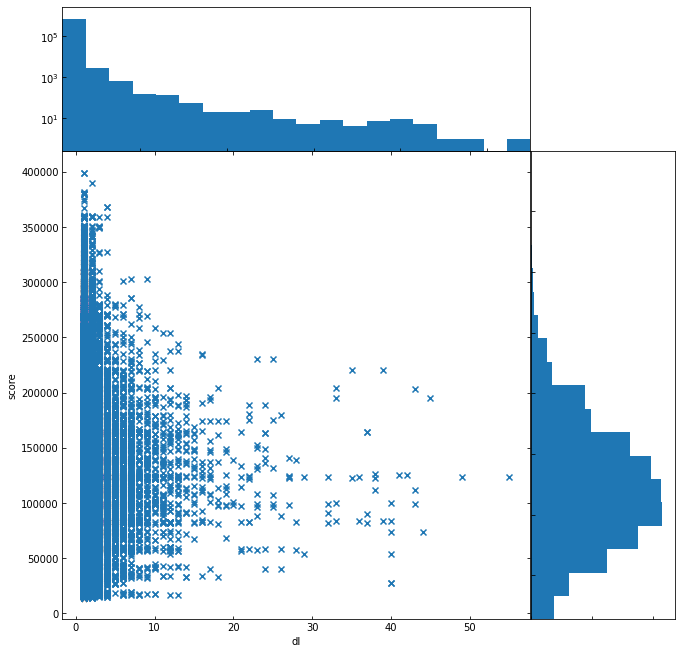

In [12]:
plot_2d_scatter(epwmstats, 'dl', 'score', plotsize=(10,10), up_hist_logscale=True)

k 7


,word,score,dl,mult
8624,GACGTCA,1.000000,25,25
14438,TGACGTC,1.000000,19,19
1747,ACGTCAT,0.944550,21,22
3610,ATGACGT,0.944314,15,15
11798,GTGACGT,0.912829,21,24
...,...,...,...,...
5550,CCCGGTT,0.285714,18,18
5544,CCCGGGC,0.285714,52,68
5421,CCCAGTG,0.285714,78,84
5310,CCAGTTT,0.285714,75,86


max dl value 347


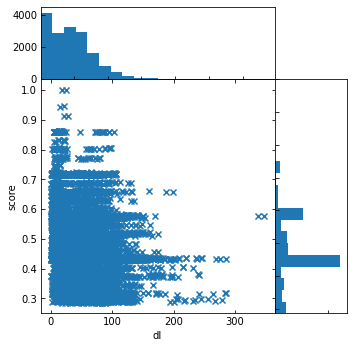

In [15]:
import pandas

k = 7
print('k',k)
it = NESAIterator( egs, k, list(edf.sa) , list(edf.lcp), list(edf.nn))
dl = list(edf.dl)

words = list()
scores = list()
dls = list()
mults = list()

for kmer in it:
    #print(kmer, it.multiplicity(), it.positions())
    #print(it.multiplicity(), it.positions())
    #print(kmer, it.multiplicity())
    words.append(kmer)
    mults.append( it.multiplicity())
    scores.append( get_normalized_motif_score(ctcf, kmer)[0]  )
    dls.append( len(  set(  dl[ it.get_start() : it.get_end() ]  ) ) )
    
epwmstats = pandas.DataFrame()
epwmstats['word'] = words
epwmstats['score'] = scores
epwmstats['dl'] = dls
epwmstats['mult'] = mults
epwmstats.sort_values('score', ascending=False, inplace=True)


display(epwmstats)
print('max dl value', max(epwmstats['dl']))

plot_2d_scatter(epwmstats, 'dl', 'score')

----

# Two background models

In order to assign a score to a k-mer that has been extracted by a given procedure, we can take into account the divergenge from the real case to a *random* one, also called background model.<br>
Here two different background models.

## Nucleotide shuffling procedure
The first one is computed by randomly shuffling the nucleotides in each sequence $S_i$, up to a given percentage. This model ensures that the 1-mer content of input sequences are preserved, however it may disrupt the k-mer composition for $k>2$. In fact, it is possible that, if sequences $S_i$ belong to a genome $G$, that this procedure may produce k-mers that do not belong to $G$. On the contrary, a pro of this method is that it try to preserve the context form which the sequences has been extracted.

In [16]:
import math
import random

random.seed(0)

iseqs = iipeaks
oseqs = ishuffling

shuff_perc = 0.2

def shuffle_seq(s):
    s = [ c for c in s.upper()]
    positions = [ i for i in range(len(s)-1) if s[i]!='N' ]
    for n in range( math.ceil(len(positions)*shuff_perc) ):
        i = random.randrange(0, len(positions) )
        j = random.randrange(0, len(positions) )
        t = s[i]
        s[i] = s[j]
        s[j] = t
    return ''.join(s)

with open(oseqs,'w') as off:
    iline = 0
    for line in open(iseqs,'r'):
        if iline%2==0:
            off.write(line)
        else:
            s = shuffle_seq(line)
            off.write(s)
            if iline < 20:
                print(line[:100], s[:100])
        iline +=1
    
print(iline)

tatttaggtctcctttgatttctttcattagtgctctctagttttcagcatccagatcttaaacatatttagtttgattcattattaacttttttgttgc CCTTTAGGTCTCGTGTCATTTCTTTCATTAGTTTTCTCTGGATTTCTTCATCCAGATCTGAAAACGATTTAATGTAATTCCTAAATAACTTATATTTGGC
CCAGTATACTGTGGCATGGTGCAGGAAACTGGATTAAAGTGATTACTGTGCTTCAGTCATTATATCTTCAAAGAAACAGAAGCTAAGTGTATTTTGTTTA TCTCTATAACGTGGGTTGGTCCTGGAAACTGGATAACAGTGGAAACTGTGCATCAGCCATTAAGTGTGCAAAGAAACAAAAGCAAGGTGTATATTCTTTA
tcttgaactcctgaccttaggtgatccacccgccctggcctaccaaagtgctgggattacaggcgtgagccaccgcacccagccAAGAAACATCCTCTTA TAGTCAACTCTTTGCCTTTGGTGAACCACACTCCCTGTCGCTCCGAAGTGGTGGGATTACGGGAGTGTGTCACCGCACTCAGGCGAGAAAAATGCTCTTT
TATTTTGCAATCTAAGGGATTTTTCTCTGCACTTCAATCAAACTGGAAAATTGAGAACCATTTGCTCCTATGTAACCTCTGCTGAACCATGACCCCAAGG TGTTATTCAATATAAGGGATCTTTCTCTGCACTGCAATCAAAAGGGAAAATTGAGGAGCATTCGCTCATATGTAACCTCAGCTGGAATAAGATTCAAACT
GAAACCAATTTAAAAATACTGCTAGCCTCTCCCTCTGTGTACTTAGCCCAGTGGTTTATCAAGCTTTTTCTAAGCATTCTACAAGCACTGGCAAGACTAT AACACGTATTTAAAAAAACTGCTAGCATCTTCCAGTTTGTACATAGCCCAGTGGTTTATCCAGGTTCTTCCCATCATTCTACGACCACTGG

In [17]:
build_DNESA(ishuffling, ishuffling_nelsa)

reading sequences
making global sequence
seqname2id 1069
global_sequence 815480
suffixes 815480
ordering suffixes
(815479, 1068) $
(435294, 536) $$$$$$$$C$C$$$$$GACCCGGCG$CCAT
(435295, 536) $$$$$$$C$C$$$$$GACCCGGCG$CCATG
(435296, 536) $$$$$$C$C$$$$$GACCCGGCG$CCATGT
(435284, 536) $$$$$C$$CC$$$$$$$$C$C$$$$$GACC
(435297, 536) $$$$$C$C$$$$$GACCCGGCG$CCATGTT
(435305, 536) $$$$$GACCCGGCG$CCATGTTTCCCTGGT
(435285, 536) $$$$C$$CC$$$$$$$$C$C$$$$$GACCC
(435298, 536) $$$$C$C$$$$$GACCCGGCG$CCATGTTT
(435306, 536) $$$$GACCCGGCG$CCATGTTTCCCTGGTG
creating LCP array
creating NN array
saving  dataframe to csv ENCFF000OXR_shuff.nelsa.csv


## Sequence re-extraction procedure 
A second procedure randomly extracts sequences from a genome $G$ by preserving the length of the sequences extracted in position $i$. In this way, the new sequences are originated formt he genome $G$, thus it is ensured that every k-mers occuring in them is a *real* k-mer. On the contrary, no restriction is ensured regarding the context from which they are extracted.

This procedure is made by using the bed tools software.

In [18]:
build_DNESA(ireextraction, ireextraction_nelsa)

reading sequences
making global sequence
seqname2id 1069
global_sequence 815480
suffixes 815480
ordering suffixes
(815479, 1068) $
(270379, 338) $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
(270380, 339) $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
(270381, 339) $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
(270382, 339) $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
(270383, 339) $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
(270384, 339) $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
(270385, 339) $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
(270386, 339) $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
(270387, 339) $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
creating LCP array
creating NN array
saving  dataframe to csv ENCFF000OXR_random.nelsa.csv


# A mutliple re-extraction precedure

We also evaluate a multiple re-extraction procedure such that multiple background peak sets are extracted and the presence of a given k-mer in a given sequence  is the result (the average) of its multiplcity in the corresponding multiple peaks.<br>
Thus, the background model is a set of sets of sequences, named $\mathbb{B} = \{ B^1, B^2, \dots, B^n \}$. Thus the multilpcity of a k-mer for the $i$-th peak is given by $ml(w, \mathbb{B}) = \frac{\sum_{1 \leq i \leq n}ml(w,B^i)}{n}$.<br>
However, this model can produce problems if we want to calculate the frequency of the kmer at the $i$-th peak.<br>
Thu we make an hypothesis that, instead of computing the average multiplcity, if we take into account backgorund sequences having lenth a factor ($>1$), then the multiplicity are comparable.

In [176]:
import wget
filename = wget.download('https://hgdownload.soe.ucsc.edu/goldenPath/hg19/bigZips/hg19.fa.gz')

In [19]:
import gzip
import statistics

hg38chrs = dict()
s = ''
sn = ''
for line in gzip.open('hg19.fa.gz', 'rt'):
    if line[0] == '>':
        if len(s) > 0:
            hg38chrs[sn] = s.upper()
        s = ''
        sn = line.strip().replace('>','')
    else:
        s += line.strip()
if len(s) > 0:
    hg38chrs[sn] = s.upper()
        
print(len(hg38chrs))
print(sum([len(v) for v in hg38chrs.values()]))

93
3137161264


In [20]:
import random
random.seed(0)

with open(imultiplere, 'w') as off:
    utimes = 10
    #imultiplere
    iline = 0
    for line in open(iipeaks,'r'):
        if line[0] == '>':
            gchr = line.strip().split(':')[0].replace('>','')
            p1 = int(line.strip().split(':')[1].split('-')[0])
            p2 = int(line.strip().split(':')[1].split('-')[1])
            l = p2-p1
            #print(gchr, p1, p2, p2-p1)
            
            ps = list()
            s = ''
            for n in range(utimes):
                si = 'N'
                while 'N' in si:
                    p = random.randint(0, len(hg38chrs[gchr]) - l)
                    si = hg38chrs[gchr][p : p+l]
                s += si+'N'
                ps.append(p)
            #print(l,line.strip())
            #print(len(s), s[:100])
            
            off.write(line.strip()+':x10:'+'-'.join([str(s)for s in ps])+'\n')
            off.write(s)
            off.write('\n')

            #if iline > 10:
            #    break
            iline += 1
    print(iline)
        

1069


In [21]:
build_DNESA(imultiplere, imultiplere_nelsa)

reading sequences
making global sequence
seqname2id 1069
global_sequence 8155869
suffixes 8155869
ordering suffixes
(8155868, 1068) $
(8155867, 1068) $$
(4770024, 595) $$AAAAAAAAAGAAAAGAAAACATAAGGTG
(7040081, 902) $$AAAAAAGGCTACTGGTCTCTCTGGCTAA
(626264, 75) $$AAAAAATTAGCCGGGCGTGATGGCGGGC
(4670109, 580) $$AAAAACAAGAAAAGCAAGCAAGTAGAAT
(4220165, 516) $$AAAAACAAGTGGCACCAAGAAATAGTTG
(7074717, 908) $$AAAAATTAGCTGGGTGTGGTTGCGGACG
(7852876, 1017) $$AAAACAGGGAAATACACTGTGTTAGTCT
(1696064, 205) $$AAAACTCAAGAGCAAAAGTGCTATTGGC
creating LCP array
creating NN array
saving  dataframe to csv ENCFF000OXR_random10.nelsa.csv


----

# A ranking procedure for k-mers based on KL divergence terms (kl_rank and norm_kl_rank)

This section shows a methodology to rank k-mers, being all of the same length $k$, by taking into account their single contribution to the calculation of a Kullback-Leibler (KL) divergence form a real case, also called foreground, and a background model $B$.<br>
Given a word length $k$, the procedure takes into account the multiplicities of the k-mers occurring at least one in the foreground sequence set $S$.<br>
The KL divergence is calculated as $ \sum_{w \in D_k(S)}p(w,S) log \frac{p(w,S)}{p(w,B)} $, where p(w,S) is the frequency of $w$ in $S$, that is computed as $\frac{ml(w,S)}{ \sum_i{|S_i|-|w|+1}}$ if sequences in $S$ do not contains $N$ characters.<br>
For practical applicatios, it is possible that a k-mer does not occurr in the backgorund set $B$, in this case a very small value is assigned to it and it is ensured that $\sum_{w \in D_k(S)}p(w,B) = 1$.<br>
Givne a k-mer, its rank is caluclated by ordering the k-mers by their values such that  $kl\_rank(w,S,B) = p(w,S) log \frac{p(w,S)}{p(w,B)}$. In this way a k-mer that is over-represented in the foregound w.r.t the background set has a positive contribution, and k-mers that are under-represented have negative contributions.

In addition, the $kl\_rank$ values can be normalized to be values in $[0,1]$ by taking into account the minimum value $kl_min = min_{w \in D_k(S)} kl\_rank(w,S,B)$ and the maximum value $kl_max = max_{w \in D_k(S)} kl\_rank(w,S,B)$, such that $norm\_kl\_rank(w,S,B) = \frac{kl\_rank(w,S,B)  - kl\_min}{kl\_max - kl\_min} $

In [22]:
import math

def get_kl_scores(k, egs, edf, rgs, rdf):
    f_kmers = dict()

    it =  NESAIterator( egs, k, list(edf.sa) , list(edf.lcp), list(edf.nn))
    for kmer in it:
        f_kmers[kmer] = it.multiplicity()

    b_kmers = dict()

    it =  NESAIterator( rgs, k, list(rdf.sa) , list(rdf.lcp), list(rdf.nn))
    for kmer in it:
        b_kmers[kmer] = it.multiplicity()

    kmers = f_kmers.keys() | b_kmers.keys()

    for kmer in kmers:
        f_kmers[kmer] = f_kmers.get(kmer,0)+1
        b_kmers[kmer] = b_kmers.get(kmer,0)+1

    f_sum = sum(f_kmers.values())
    b_sum = sum(b_kmers.values())

    scores = dict()
    sorted_scores = list()
    for kmer in kmers:
        f_kmers[kmer] = f_kmers[kmer]/f_sum
        b_kmers[kmer] = b_kmers[kmer]/b_sum
        scores[kmer] = f_kmers[kmer] * math.log( f_kmers[kmer] / b_kmers[kmer] )
        sorted_scores.append((scores[kmer],kmer))
    sorted_scores = sorted(sorted_scores, reverse=True)
    
    min_score = min(scores.values())
    max_score = max(scores.values())
    
    norm_sorted_scores = list()
    for s in sorted_scores:
        norm_sorted_scores.append(  (  (s[0]-min_score)/(max_score - min_score), s[1] )  )
        
    return sorted_scores, norm_sorted_scores
    

----

# A DL-aware scoring procedure for k-mers of variable length (norm_kl_score)
This section shows a scoring procedure that can be used ot recognize statistically over-represented k-mers in a set of sequence, such that the computation of the score for a specific k-mer does not depend form the computaiton of the score of any other k-mer.<br>
In addiction, this procedure enables to take into account the contribution that each sequence in the input set $S$ has to the multiplicity of the k-mer.<br>
The only constraint is that $|S_i| = |B_i|$.<br>
Given a k-mer $w \in D_k(G)$, the score of $w$ is calculated by normalizing the divergence $KL(w,S,B) = \sum_i{ p(w,S_i) log \frac{p(w,S_i)}{p(w,B_i)} }$ for the maximum value of KL that the distribution $p(w,S_i)$ can reach.<br>
In order to estimate the maximum KL value for the distribution $p(w,S_i)$, we takes into account a reordering of the sequences $S_i$, referred to as $\widehat{S}$, such that $p(w,\widehat{S_i})\geq p(w,\widehat{S_{i+1}})$, and a reodering $\bar{S}$ such that $p(w,\bar{S_i})\leq p(w,\bar{S_{i+1}})$.<br>
It can be shown that the given score is not the maximum that the KL divergence can reach, when $p(w,S_i), p(w,B_i) \neq 0$, however, we can empirically show that it is a good upperbound to the KL value in practical applications.<br>
Finally, the score for a given k-mer $w$ is $norm\_kl\_score(w,S,B) = \frac{KL(w,S,B)}{KL(w,\widehat{S},\bar{S})}$.

In [23]:
def get_m_distr(dnesa, istart, iend):
    distr = dict()
    for i in range(istart, iend):
        distr[ dnesa.dl[i] ] = distr.get(dnesa.dl[i], 0)+1
    return distr

def m_dsitr_to_seq_freq(m_distr, seq_lengths, k):
    f_distr = dict()
    for s,v in m_distr.items():
        f_distr[s] = v/( seq_lengths[s]-k+1 )
    return f_distr

def make_prob_distr(idistr):
    odistr = dict()
    s = sum(idistr.values())
    for k,v in idistr.items():
        odistr[k] = v/s
    return odistr

def add_unzeros(idistr, max_k, miss_value=0.0000001):
    odistr = dict()
    for i in range(max_k):
        odistr[i] = idistr.get(i, miss_value)
    return odistr

def calculate_kl(d1,d2):
    kl = 0
    for k in d1.keys():
        kl += d1[k] * math.log(d1[k]/d2[k])
    return kl
        

def calculate_norm_kl(kmer, egs, e_dnesa, rgs, r_dnesa, seq_lengths, nof_peaks):
    es, ef = e_dnesa.search(kmer)
    rs, rf = r_dnesa.search(kmer)
    if es and rs:
        d1 = make_prob_distr( add_unzeros( m_dsitr_to_seq_freq( get_m_distr( e_dnesa, es, ef ), seq_lengths, len(kmer) ), nof_peaks) )
        d2 = make_prob_distr( add_unzeros( m_dsitr_to_seq_freq( get_m_distr( r_dnesa, rs, rf ), seq_lengths, len(kmer) ), nof_peaks) )

        dd = list()
        for k,v in d1.items():
            dd.append( (v,k) )
        dd = sorted( dd )
        d1m = dict()
        for i in range(len(dd)):
            d1m[ dd[i][1] ] = dd[ len(dd)-i-1 ][0]

        return calculate_kl(d1,d2) / calculate_kl(d1,d1m)
    return 0.0
    

----

# A comparision on fixed-length word sets using a nucleotide shuffling model

In this section we show a comparison between the two scoring procedures $kl\_rank$ and $norm\_kl\_score$ on sets of words of fixed (same) length $k$, by taking into account the nucleotide shuffling model.


In [24]:
epeaks, es2n, egs = read_global_sequence(iipeaks)
edf = pandas.read_csv(iipeaks_nelsa)
print(len(epeaks), len(es2n), len(egs))
e_dnesa = DNESA(list(edf.sa), list(edf.lcp), list(edf.nn), list(edf.dl), egs)

rpeaks, rs2n, rgs = read_global_sequence(ishuffling)
rdf = pandas.read_csv(ishuffling_nelsa)
print(len(rpeaks), len(rs2n), len(rgs))
r_dnesa = DNESA(list(rdf.sa), list(rdf.lcp), list(rdf.nn), list(rdf.dl), rgs)

1069 1069 815480
1069 1069 815480


In [25]:
ctcf = read_jaspar(imotif)

In addition a symmetric KL distance and a generalized Jaccard similarity calculated on top of DL vectors are taken into accont.

In [26]:
def calulcate_generalized_jaccard(d1, d2):
    nom = 0.0
    den = 0.0
    for k in (d1.keys()|d2.keys()):
        nom += max( d1.get(k,0), d2.get(k,0) )
        den += min( d1.get(k,0), d2.get(k,0) )
    if den > 0:
        return nom/den
    else:
        return 0

def calculate_symmetric_kl(d1, d2):
    return (calculate_kl(d1,d2)+calculate_kl(d2,d1))/2

In [27]:
k = 5

kl_rank, norm_kl_rank =  get_kl_scores(k, egs, e_dnesa, rgs, r_dnesa)
#print(kl_rank)

seq_lengths = dict()
for i in range(len(epeaks)):
    seq_lengths[i] = len(epeaks[i][0])
nof_peaks = len(epeaks)

mult = list()
dl = list()
norm_pwm_score = list()
norm_kl = list()
kl_to = list()
symmetric_kl = list()
jaccard = list()

for s in kl_rank:
    kmer = s[1]
    
    norm_pwm_score.append( get_normalized_motif_score(ctcf, kmer)[0] )
    norm_kl.append( calculate_norm_kl(kmer, egs, e_dnesa, rgs, r_dnesa, seq_lengths, nof_peaks ) )
    ks, ke = e_dnesa.search(kmer)
    if ks:
        rs, rf = r_dnesa.search(kmer)
        if rs:
            d1 = get_m_distr( e_dnesa, ks, ke )
            d2 = get_m_distr( r_dnesa, rs, rf )
            jaccard.append(calulcate_generalized_jaccard(d1,d2))
            
            d1 = make_prob_distr( add_unzeros( m_dsitr_to_seq_freq( get_m_distr( e_dnesa, ks, ke ), seq_lengths, len(kmer) ), nof_peaks) )
            d2 = make_prob_distr( add_unzeros( m_dsitr_to_seq_freq( get_m_distr( r_dnesa, rs, rf ), seq_lengths, len(kmer) ), nof_peaks) )
            kl_to.append( calculate_kl(d1,d2) )
            symmetric_kl.append( calculate_symmetric_kl(d1,d2) )
        else:
            symmetric_kl.append(0)
            jaccard.append(0)
        
        mult.append(ke-ks)
        dl.append( len(set(edf.dl[ks:ke])))
    else:
        mult.append(0)
        dl.append(0)
        symmetric_kl.append(0)
        jaccard.append(0)
        
import pandas
exp1_df = pandas.DataFrame()
exp1_df['kmer'] = [ s[1] for s in kl_rank ]
exp1_df['norm_pwm_score'] = norm_pwm_score
exp1_df['dl'] = dl
exp1_df['mult'] = mult
exp1_df['kl_rank'] = [ s[0] for s in kl_rank ]
exp1_df['norm_kl_rank'] = [ s[0] for s in norm_kl_rank ]
exp1_df['norm_kl_to'] = norm_kl
exp1_df['norm_kl_score'] = norm_kl
exp1_df['symmetric_kl'] = symmetric_kl
exp1_df['jaccard'] = jaccard

print('-'*40)
display(exp1_df)

exp1_df.to_csv('scores.best5000.shuffle.k'+str(k)+'.csv')

----------------------------------------


,kmer,norm_pwm_score,dl,mult,kl_rank,norm_kl_rank,norm_kl_to,norm_kl_score,symmetric_kl,jaccard
0,AAAAA,0.363992,816,3876,0.002348,1.000000,0.207170,0.207170,1.478982,2.398803
1,TTTTT,0.364613,794,3710,0.001842,0.813549,0.175760,0.175760,1.426275,2.264768
2,CCCAG,0.405396,690,1544,0.001098,0.539683,0.381233,0.381233,2.562845,2.519708
3,CTGGG,0.406679,702,1569,0.001077,0.531863,0.415574,0.415574,2.676896,2.540890
4,AGAAA,0.407498,879,2324,0.001005,0.505565,0.359835,0.359835,1.482388,2.069767
...,...,...,...,...,...,...,...,...,...,...
1019,ATAAT,0.534262,613,1033,-0.000308,0.022037,0.276490,0.276490,2.839491,2.514970
1020,TAATA,0.563996,573,939,-0.000316,0.018768,0.261588,0.261588,2.871598,2.568144
1021,TATAT,0.413876,480,865,-0.000318,0.018306,0.273796,0.273796,3.353620,2.888889
1022,TTATA,0.556499,573,852,-0.000355,0.004690,0.285461,0.285461,3.020412,2.634103


In [28]:
display(exp1_df)

,kmer,norm_pwm_score,dl,mult,kl_rank,norm_kl_rank,norm_kl_to,norm_kl_score,symmetric_kl,jaccard
0,AAAAA,0.363992,816,3876,0.002348,1.000000,0.207170,0.207170,1.478982,2.398803
1,TTTTT,0.364613,794,3710,0.001842,0.813549,0.175760,0.175760,1.426275,2.264768
2,CCCAG,0.405396,690,1544,0.001098,0.539683,0.381233,0.381233,2.562845,2.519708
3,CTGGG,0.406679,702,1569,0.001077,0.531863,0.415574,0.415574,2.676896,2.540890
4,AGAAA,0.407498,879,2324,0.001005,0.505565,0.359835,0.359835,1.482388,2.069767
...,...,...,...,...,...,...,...,...,...,...
1019,ATAAT,0.534262,613,1033,-0.000308,0.022037,0.276490,0.276490,2.839491,2.514970
1020,TAATA,0.563996,573,939,-0.000316,0.018768,0.261588,0.261588,2.871598,2.568144
1021,TATAT,0.413876,480,865,-0.000318,0.018306,0.273796,0.273796,3.353620,2.888889
1022,TTATA,0.556499,573,852,-0.000355,0.004690,0.285461,0.285461,3.020412,2.634103


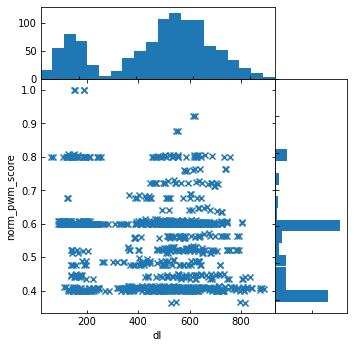

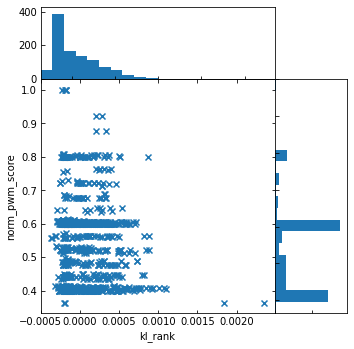

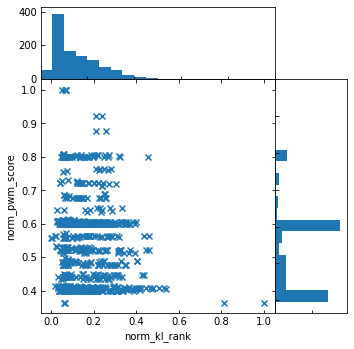

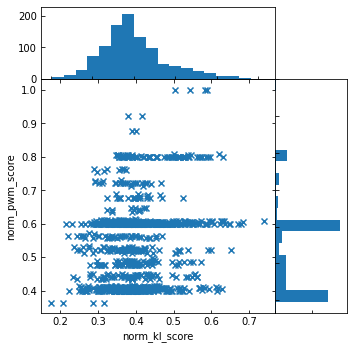

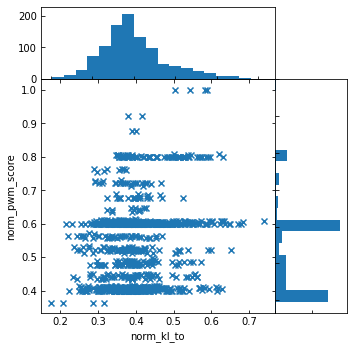

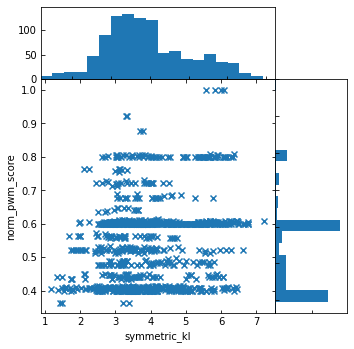

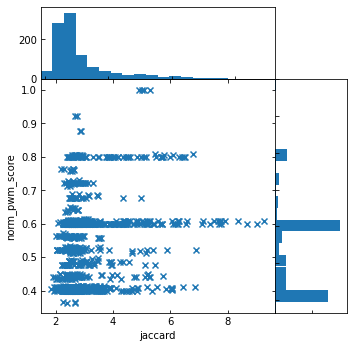

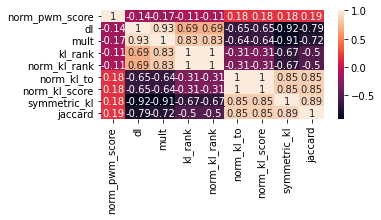

In [29]:
df = exp1_df

plot_2d_scatter(df, 'dl', 'norm_pwm_score')

plot_2d_scatter(df, 'kl_rank', 'norm_pwm_score')
plot_2d_scatter(df, 'norm_kl_rank', 'norm_pwm_score')
plot_2d_scatter(df, 'norm_kl_score', 'norm_pwm_score')
plot_2d_scatter(df, 'norm_kl_to', 'norm_pwm_score')
plot_2d_scatter(df, 'symmetric_kl', 'norm_pwm_score')
plot_2d_scatter(df, 'jaccard', 'norm_pwm_score')

import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
plt.figure(figsize=(5,2))
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

----

# A comparision on fixed-length word sets using a sequence re-extraction model

In this section we show a comparison between the two scoring procedures $kl\_rank$ and $norm\_kl\_score$ on sets of words of fixed (same) length $k$, by taking into account the nucleotide shuffling model.


In [32]:
epeaks, es2n, egs = read_global_sequence(iipeaks)
edf = pandas.read_csv(iipeaks_nelsa)
print(len(epeaks), len(es2n), len(egs))
e_dnesa = DNESA(list(edf.sa), list(edf.lcp), list(edf.nn), list(edf.dl), egs)

rpeaks, rs2n, rgs = read_global_sequence(ireextraction)
rdf = pandas.read_csv(ireextraction_nelsa)
print(len(rpeaks), len(rs2n), len(rgs))
r_dnesa = DNESA(list(rdf.sa), list(rdf.lcp), list(rdf.nn), list(rdf.dl), rgs)

1069 1069 815480
1069 1069 815480


In [33]:
ctcf = read_jaspar(imotif)

In addition a symmetric KL distance and a generalized Jaccard similarity calculated on top of DL vectors are taken into accont.

In [35]:
k = 4

kl_rank, norm_kl_rank =  get_kl_scores(k, egs, e_dnesa, rgs, r_dnesa)
#print(kl_rank)

seq_lengths = dict()
for i in range(len(epeaks)):
    seq_lengths[i] = len(epeaks[i][0])
nof_peaks = len(epeaks)

mult = list()
dl = list()
norm_pwm_score = list()
norm_kl = list()
kl_to = list()
symmetric_kl = list()
jaccard = list()

for s in kl_rank:
    kmer = s[1]
    
    norm_pwm_score.append( get_normalized_motif_score(ctcf, kmer)[0] )
    norm_kl.append( calculate_norm_kl(kmer, egs, e_dnesa, rgs, r_dnesa, seq_lengths, nof_peaks ) )
    ks, ke = e_dnesa.search(kmer)
    if ks:
        rs, rf = r_dnesa.search(kmer)
        if rs:
            d1 = get_m_distr( e_dnesa, ks, ke )
            d2 = get_m_distr( r_dnesa, rs, rf )
            jaccard.append(calulcate_generalized_jaccard(d1,d2))
            
            d1 = make_prob_distr( add_unzeros( m_dsitr_to_seq_freq( get_m_distr( e_dnesa, ks, ke ), seq_lengths, len(kmer) ), nof_peaks) )
            d2 = make_prob_distr( add_unzeros( m_dsitr_to_seq_freq( get_m_distr( r_dnesa, rs, rf ), seq_lengths, len(kmer) ), nof_peaks) )
            kl_to.append( calculate_kl(d1,d2) )
            symmetric_kl.append( calculate_symmetric_kl(d1,d2) )
        else:
            symmetric_kl.append(0)
            jaccard.append(0)
        
        mult.append(ke-ks)
        dl.append( len(set(edf.dl[ks:ke])))
    else:
        mult.append(0)
        dl.append(0)
        symmetric_kl.append(0)
        jaccard.append(0)
        
import pandas
exp1_df = pandas.DataFrame()
exp1_df['kmer'] = [ s[1] for s in kl_rank ]
exp1_df['norm_pwm_score'] = norm_pwm_score
exp1_df['dl'] = dl
exp1_df['mult'] = mult
exp1_df['kl_rank'] = [ s[0] for s in kl_rank ]
exp1_df['norm_kl_rank'] = [ s[0] for s in norm_kl_rank ]
exp1_df['norm_kl_score'] = norm_kl
exp1_df['kl_to'] = kl_to
exp1_df['symmetric_kl'] = symmetric_kl
exp1_df['jaccard'] = jaccard

print('-'*40)
display(exp1_df)

exp1_df.to_csv('scores.re-extract.k'+str(k)+'.csv')

----------------------------------------


,kmer,norm_pwm_score,dl,mult,kl_rank,norm_kl_rank,norm_kl_score,kl_to,symmetric_kl,jaccard
0,CCGC,0.500000,422,1458,0.001947,1.000000,0.691546,7.479945,7.682387,13.406015
1,CGCG,0.500000,250,973,0.001873,0.986269,0.785872,8.525778,9.321407,35.312500
2,GCGG,0.500000,428,1435,0.001744,0.962042,0.697282,7.557136,7.865386,12.899281
3,GCGC,0.500000,361,1293,0.001666,0.947435,0.691465,7.483941,7.786586,13.913043
4,CCGG,0.500000,459,1509,0.001568,0.929202,0.600788,6.436123,6.535598,8.513514
...,...,...,...,...,...,...,...,...,...,...
251,ATAT,0.508922,950,3449,-0.001888,0.283470,0.589735,2.413762,2.114141,2.994324
252,AAAT,0.505494,1045,6400,-0.002008,0.260941,1.241281,1.551250,1.125246,2.165842
253,ATTT,0.503428,1043,6480,-0.002029,0.256993,1.095944,1.431822,1.049046,2.087814
254,AAAA,0.402549,1042,9677,-0.003208,0.036703,0.997365,2.018141,1.486779,2.599295


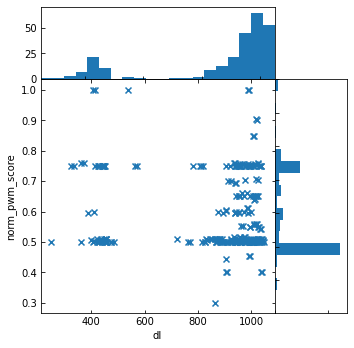

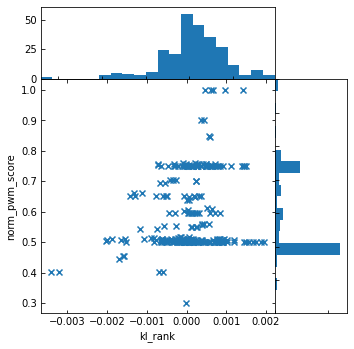

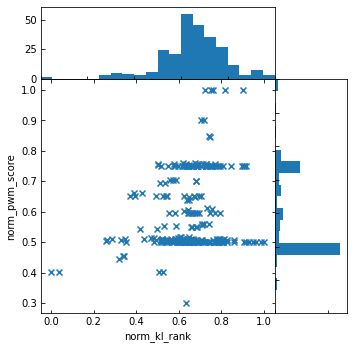

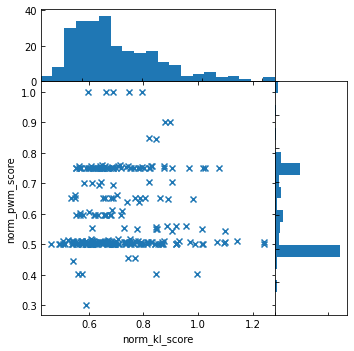

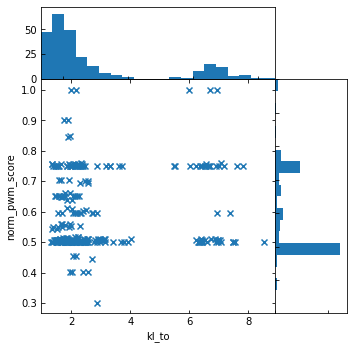

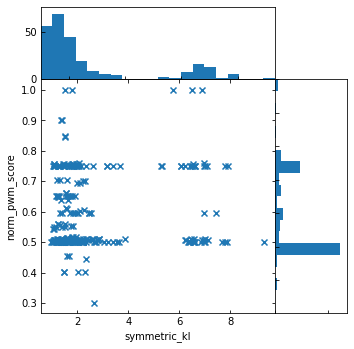

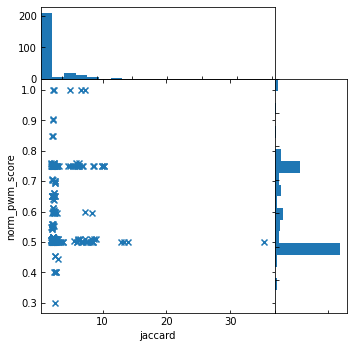

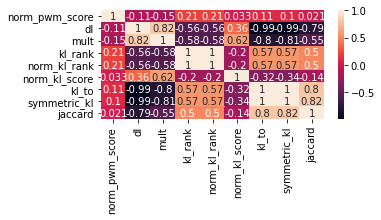

In [36]:
df = exp1_df

plot_2d_scatter(df, 'dl', 'norm_pwm_score')

plot_2d_scatter(df, 'kl_rank', 'norm_pwm_score')
plot_2d_scatter(df, 'norm_kl_rank', 'norm_pwm_score')
plot_2d_scatter(df, 'norm_kl_score', 'norm_pwm_score')
plot_2d_scatter(df, 'kl_to', 'norm_pwm_score')
plot_2d_scatter(df, 'symmetric_kl', 'norm_pwm_score')
plot_2d_scatter(df, 'jaccard', 'norm_pwm_score')

import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
plt.figure(figsize=(5,2))
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

----

# A simple procedure to extract maximal words given a DL threshold

A simple procedure to extract word as long as possible such that they are present in a certain percentage of sequences is given in what follows.<br>
The aim of the procedure is to extend a given word $w$ ultil the support threshold is satisfied.<br>
Thus, given a threshold $t$, which represent a minimum number of sequences where words must occurr, and a word $w$ such that $dl(w,S)\geq t$,  $w$ is considered maximal if there not exist an elongation of $w$, $wx : x \in \{A,C,G,T\}$, such that $dl(wx,S)\geq t$.<br>
Maximal words are extracted by the algorithm. In contrast, words that satisfy the threshold but that are not maximal, are discarded and their elogations are taken into account.<br>
The procedure is a recursive algoritm which starts form 1-mers and elongate them until maximal words are reached. If 1-mers are considered as roots of a prefix tree, it can be shown that this bottom-up procedure extracts the same words of a top-down procedure which, in constrats, works by aggregating *unfrequent* words.


In [37]:
def get_intervals(istart, iend, k, dnesa):
    """
    Given a word length k, a DNESA, and an initial lcp-interval with coordinates istar-iend which represent a k-mer w, 
    the procedures searches the lcp-interval of the 4 elongations wA, wC, wG and wT.
    The procedure is inefficient since it can be done by a dicotomic seach rather than a linear scan.
    """
    intervals = list()
    
    rstart = istart
    while (rstart < iend) and (dnesa.nn[rstart] <= k) :
        rstart += 1
    
    while rstart < iend:
        rend = rstart + 1
        c = dnesa.gs[ dnesa.sa[rstart] +k ]
        while (rend < iend) and (dnesa.nn[ rend ] >=k ) and ( dnesa.gs[ dnesa.sa[rend] +k ] == c ):
            rend += 1
        intervals.append( (c, rstart, rend) )
        rstart = rend
    return intervals


#good_words = list()
def up_until_dl_thr(w, istart, iend, k, cdl, dl_thr, dnesa, good_words):
    """
    A recursive procedure to extend a word w into an extension wX until dl(wX,S) >= dl_thr, the input support threshold.
    Found maximal words are added up to the list good_words
    """
    intervals = get_intervals(istart, iend, k+1, dnesa)
    #print(intervals)

    good_intervals = list()
    for interval in intervals:
        idl = len(set( dnesa.dl[interval[1]: interval[2]] ))
        if idl >= dl_thr:
            good_intervals.append((interval, idl))

    #print(good_intervals)

    if len(good_intervals)>0:
        for interval in good_intervals:
            up_until_dl_thr(  w+interval[0][0], interval[0][1], interval[0][2], k+1, interval[1], dl_thr, dnesa, good_words )
    else:
        #print(w, cdl)
        good_words.append( (w,istart,iend) )



The support threshold is named *dl_thr_perc* and it is defined as a percentage of the input set $S$.

In [38]:
import math

def extract_maximal_dl_words(iseqs, inelsa, dl_thr_perc):
    # we firstly read the input set S and the DNESA data structure
    epeaks, es2n, egs = read_global_sequence(iseqs)
    edf = pandas.read_csv(inelsa)
    print(len(epeaks), len(es2n), len(egs))
    e_dnesa = DNESA(list(edf.sa), list(edf.lcp), list(edf.nn), list(edf.dl), egs)


    total_dl = len(set(e_dnesa.dl))
    print('total peaks',total_dl)

    #dl_thr_perc = 0.6  #<---- this is the threshold parameter
    dl_thr = math.ceil( total_dl*dl_thr_perc )
    print('thr',dl_thr_perc, '=', dl_thr)


    istart = 0
    iend = len(e_dnesa.gs)

    print('getting 0 intervals')
    intervals = get_intervals(istart, iend, 0, e_dnesa)
    print(intervals)

    good_words = list() 
    for interval in intervals:
        print(interval)
        up_until_dl_thr( interval[0], interval[1], interval[2], 0,  len(set(e_dnesa.dl[interval[1]:interval[2]])), dl_thr, e_dnesa, good_words  )
        
    return good_words

In [39]:
good_words = extract_maximal_dl_words(iipeaks, iipeaks_nelsa, 0.8)
print(len(good_words),'extracted words')

1069 1069 815480
total peaks 1069
thr 0.8 = 856
getting 0 intervals
[('A', 1108, 227350), ('C', 227350, 408259), ('G', 408259, 590054), ('T', 590054, 815480)]
('A', 1108, 227350)
('C', 227350, 408259)
('G', 408259, 590054)
('T', 590054, 815480)
196 extracted words


In [40]:
print(sorted([ s[0] for s in good_words]))
print(len(good_words))

['AAAAT', 'AAAC', 'AAAG', 'AAAT', 'AACA', 'AACC', 'AACT', 'AAGA', 'AAGC', 'AAGG', 'AAGT', 'AATA', 'AATC', 'AATG', 'AATT', 'ACAA', 'ACAC', 'ACAG', 'ACAT', 'ACCA', 'ACCC', 'ACCT', 'ACTA', 'ACTC', 'ACTG', 'ACTT', 'AGAAA', 'AGAC', 'AGAG', 'AGAT', 'AGCA', 'AGCC', 'AGCT', 'AGGA', 'AGGC', 'AGGG', 'AGGT', 'AGTA', 'AGTC', 'AGTG', 'AGTT', 'ATAA', 'ATAC', 'ATAG', 'ATAT', 'ATCA', 'ATCC', 'ATCT', 'ATGA', 'ATGC', 'ATGG', 'ATGT', 'ATTA', 'ATTC', 'ATTG', 'ATTTT', 'CAAA', 'CAAC', 'CAAG', 'CAAT', 'CACA', 'CACC', 'CACT', 'CAGA', 'CAGC', 'CAGG', 'CAGT', 'CATA', 'CATC', 'CATG', 'CATT', 'CCAA', 'CCAC', 'CCAG', 'CCAT', 'CCCA', 'CCCT', 'CCTA', 'CCTC', 'CCTG', 'CCTT', 'CGT', 'CTAA', 'CTAC', 'CTAG', 'CTAT', 'CTCA', 'CTCC', 'CTCT', 'CTGA', 'CTGC', 'CTGG', 'CTGT', 'CTTA', 'CTTC', 'CTTG', 'CTTT', 'GAAA', 'GAAC', 'GAAG', 'GAAT', 'GACA', 'GACT', 'GAGA', 'GAGC', 'GAGG', 'GAGT', 'GATA', 'GATG', 'GATT', 'GCAA', 'GCAC', 'GCAG', 'GCAT', 'GCCA', 'GCCT', 'GCTA', 'GCTC', 'GCTG', 'GCTT', 'GGAA', 'GGAG', 'GGAT', 'GGCA', 'GGCT

---- 

# A comparison on variable-length words, with the sequence re-extraction model

In [41]:
import pandas 
epeaks, es2n, egs = read_global_sequence(iipeaks)
edf = pandas.read_csv(iipeaks_nelsa)
print(len(epeaks), len(es2n), len(egs))
e_dnesa = DNESA(list(edf.sa), list(edf.lcp), list(edf.nn), list(edf.dl), egs)

rpeaks, rs2n, rgs = read_global_sequence(ireextraction)
rdf = pandas.read_csv(ireextraction_nelsa)
print(len(rpeaks), len(rs2n), len(rgs))
r_dnesa = DNESA(list(rdf.sa), list(rdf.lcp), list(rdf.nn), list(rdf.dl), rgs)

r10peaks, r10s2n, r10gs = read_global_sequence(imultiplere)
r10df = pandas.read_csv(imultiplere_nelsa)
print(len(r10peaks), len(r10s2n), len(r10gs))
r10_dnesa = DNESA(list(r10df.sa), list(r10df.lcp), list(r10df.nn), list(r10df.dl), r10gs)

ctcf = read_jaspar(imotif)

1069 1069 815480
1069 1069 815480
1069 1069 8155869


We first need to calculate $kl\_rank$ for words in a range of lengths.

In [42]:
d_kl_rank = dict()
d_norm_kl_rank = dict()

for k in range(2,7):
    print(k)
    k_kl_rank, k_norm_kl_rank =  get_kl_scores(k, egs, e_dnesa, rgs, r_dnesa)
    for s in k_kl_rank:
        d_kl_rank[ s[1] ] = s[0]
    for s in k_norm_kl_rank:
        d_norm_kl_rank[ s[1] ] = s[0]


2
3
4
5
6


Now we extract the words by usgin the simple procedure based on DL threshold

In [43]:
dl_thr = 0.8
extracted_words = extract_maximal_dl_words(iipeaks,iipeaks_nelsa, dl_thr)
print(len(extracted_words),'extracted words')

1069 1069 815480
total peaks 1069
thr 0.8 = 856
getting 0 intervals
[('A', 1108, 227350), ('C', 227350, 408259), ('G', 408259, 590054), ('T', 590054, 815480)]
('A', 1108, 227350)
('C', 227350, 408259)
('G', 408259, 590054)
('T', 590054, 815480)
196 extracted words


In [44]:
seq_lengths = dict()
for i in range(len(epeaks)):
    seq_lengths[i] = len(epeaks[i][0])
nof_peaks = len(epeaks)

kl_rank = list()
norm_kl_rank = list()
mult = list()
dl = list()
norm_pwm_score = list()
norm_kl = list()
kl_to = list()
norm_kl10 = list()
symmetric_kl = list()
jaccard = list()

for kmer in extracted_words:
    kmer = kmer[0]
    norm_pwm_score.append( get_normalized_motif_score(ctcf, kmer)[0] )
    
    kl_rank.append( d_kl_rank.get(kmer, 0) )
    norm_kl_rank.append( d_norm_kl_rank.get(kmer, 0) )
    
    norm_kl.append( calculate_norm_kl(kmer, egs, e_dnesa, rgs, r_dnesa, seq_lengths, nof_peaks ) )
    norm_kl10.append( calculate_norm_kl(kmer, egs, e_dnesa, r10gs, r10_dnesa, seq_lengths, nof_peaks ) )
    
    ks, ke = e_dnesa.search(kmer)
    if ks:
        rs, rf = r_dnesa.search(kmer)
        if rs:
            d1 = get_m_distr( e_dnesa, ks, ke )
            d2 = get_m_distr( r_dnesa, rs, rf )
            jaccard.append(calulcate_generalized_jaccard(d1,d2))
            
            d1 = make_prob_distr( add_unzeros( m_dsitr_to_seq_freq( get_m_distr( e_dnesa, ks, ke ), seq_lengths, len(kmer) ), nof_peaks) )
            d2 = make_prob_distr( add_unzeros( m_dsitr_to_seq_freq( get_m_distr( r_dnesa, rs, rf ), seq_lengths, len(kmer) ), nof_peaks) )
            kl_to.append( calculate_kl(d1,d2) )
            symmetric_kl.append( calculate_symmetric_kl(d1,d2) )
        else:
            symmetric_kl.append(0)
            jaccard.append(0)
        
        mult.append(ke-ks)
        dl.append( len(set(edf.dl[ks:ke])))
    else:
        mult.append(0)
        dl.append(0)
        symmetric_kl.append(0)
        jaccard.append(0)
        
import pandas
exp1_df = pandas.DataFrame()
exp1_df['kmer'] = [kmer[0] for kmer in extracted_words]
exp1_df['norm_pwm_score'] = norm_pwm_score
exp1_df['dl'] = dl
exp1_df['mult'] = mult
exp1_df['kl_rank'] = kl_rank
exp1_df['norm_kl_rank'] = norm_kl_rank
exp1_df['norm_kl_score'] = norm_kl
exp1_df['kl_to'] = kl_to
exp1_df['norm_kl10_score'] = norm_kl
exp1_df['symmetric_kl'] = symmetric_kl
exp1_df['jaccard'] = jaccard

print('-'*40)
display(exp1_df)

exp1_df.to_csv('scores.best5000.re-extract.simple-maximal.'+str(dl_thr)+'.csv')

----------------------------------------


,kmer,norm_pwm_score,dl,mult,kl_rank,norm_kl_rank,norm_kl_score,kl_to,norm_kl10_score,symmetric_kl,jaccard
0,AAAAT,0.404395,888,2324,-0.001051,0.240003,0.623929,2.967729,0.623929,2.542205,2.858156
1,AAAC,0.500000,1011,4438,-0.000076,0.622064,0.853270,1.784632,0.853270,1.446711,2.134958
2,AAAG,0.500000,1048,5726,-0.000159,0.606551,1.240753,1.495226,1.240753,1.057911,2.064215
3,AAAT,0.505494,1045,6400,-0.002008,0.260941,1.241281,1.551250,1.241281,1.125246,2.165842
4,AACA,0.505494,1008,4503,-0.000481,0.546251,0.791837,1.746191,0.791837,1.406797,2.125862
...,...,...,...,...,...,...,...,...,...,...,...
191,TTGT,0.503428,996,3971,-0.000654,0.514032,0.650671,1.715792,0.650671,1.466158,2.321298
192,TTTA,0.508423,1022,5244,-0.001637,0.330410,0.813638,1.573795,0.813638,1.241354,2.183803
193,TTTCT,0.406738,873,2238,-0.000475,0.454696,0.634024,3.207444,0.634024,2.806399,2.790660
194,TTTG,0.542705,1035,5081,-0.001169,0.417684,0.905044,1.333458,0.905044,1.037213,2.051856


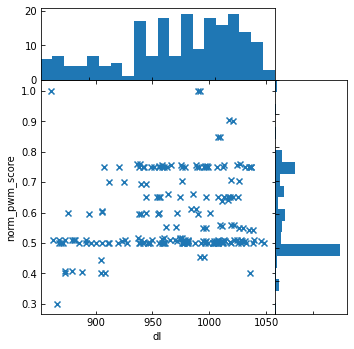

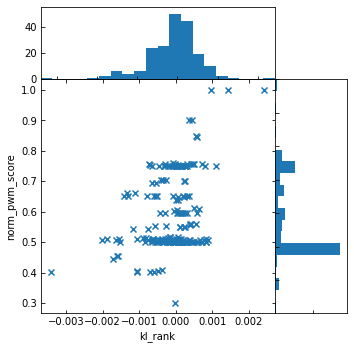

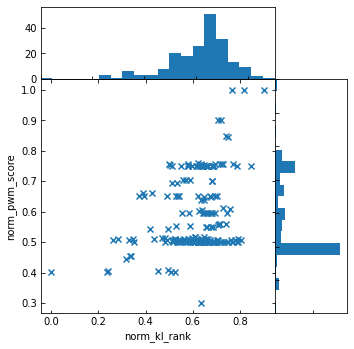

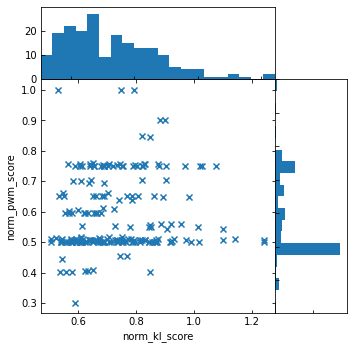

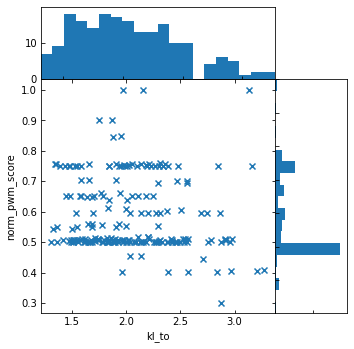

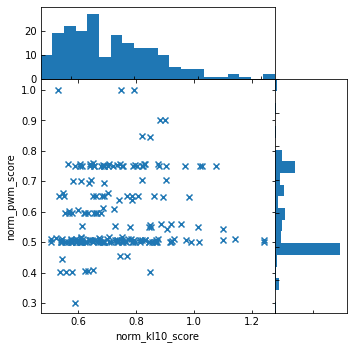

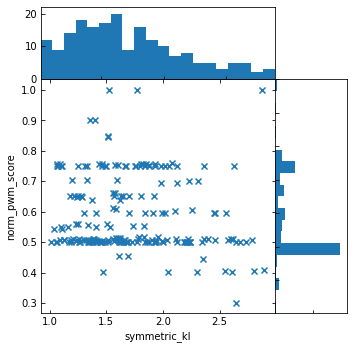

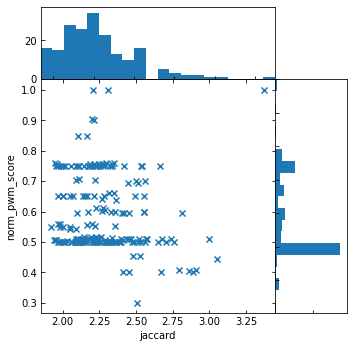

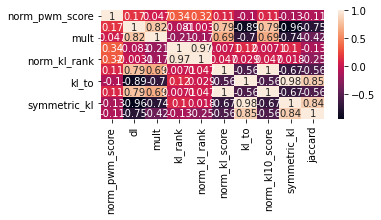

In [45]:
%matplotlib inline
df = exp1_df

plot_2d_scatter(df, 'dl', 'norm_pwm_score')

plot_2d_scatter(df, 'kl_rank', 'norm_pwm_score')
plot_2d_scatter(df, 'norm_kl_rank', 'norm_pwm_score')
plot_2d_scatter(df, 'norm_kl_score', 'norm_pwm_score')
plot_2d_scatter(df, 'kl_to', 'norm_pwm_score')
plot_2d_scatter(df, 'norm_kl10_score', 'norm_pwm_score')
plot_2d_scatter(df, 'symmetric_kl', 'norm_pwm_score')
plot_2d_scatter(df, 'jaccard', 'norm_pwm_score')

import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
plt.figure(figsize=(5,2))
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

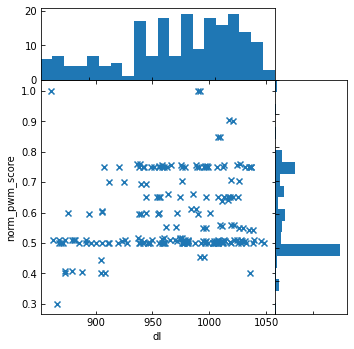

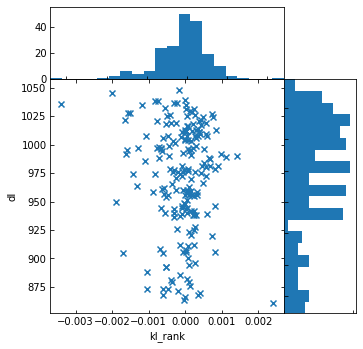

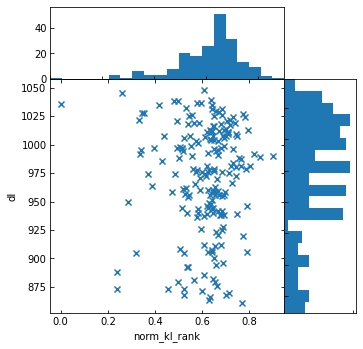

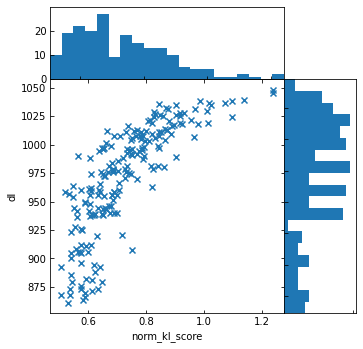

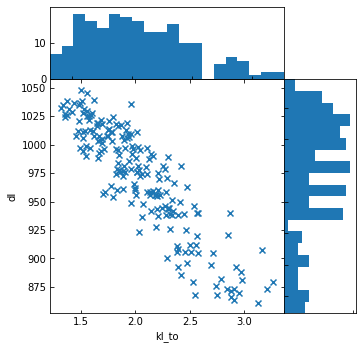

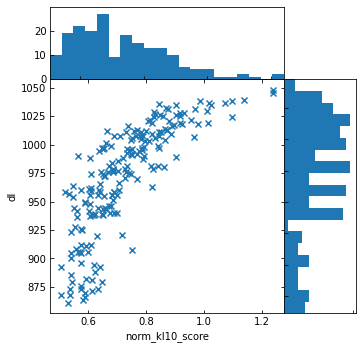

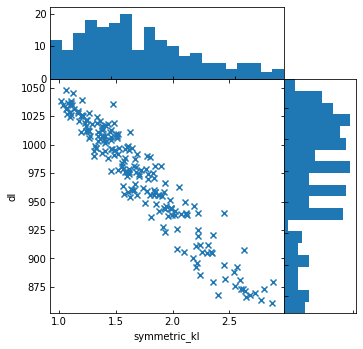

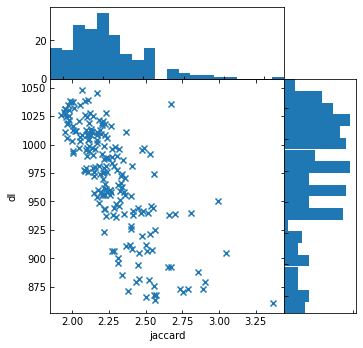

In [46]:
df = exp1_df

plot_2d_scatter(df, 'dl', 'norm_pwm_score')

plot_2d_scatter(df, 'kl_rank', 'dl')
plot_2d_scatter(df, 'norm_kl_rank', 'dl')
plot_2d_scatter(df, 'norm_kl_score', 'dl')
plot_2d_scatter(df, 'kl_to', 'dl')
plot_2d_scatter(df, 'norm_kl10_score', 'dl')
plot_2d_scatter(df, 'symmetric_kl', 'dl')
plot_2d_scatter(df, 'jaccard', 'dl')

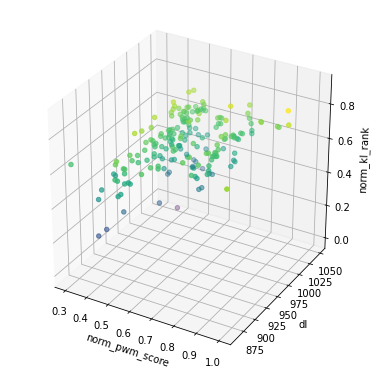

In [47]:
plot_3d_scatter(df, 'norm_pwm_score',  'dl', 'norm_kl_rank', 'norm_kl_rank', plotsize=(5,5))

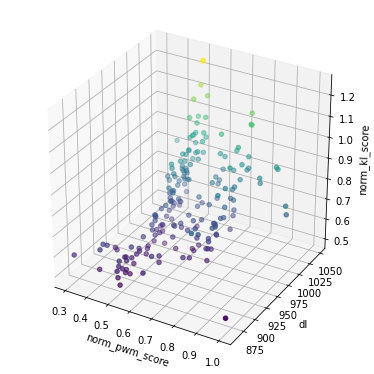

In [49]:
plot_3d_scatter(df, 'norm_pwm_score',  'dl', 'norm_kl_score', 'norm_kl_score' , plotsize=(5,5))

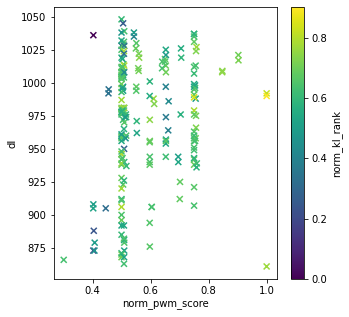

In [50]:
plot_2d_scatter_colors(df, 'norm_pwm_score',  'dl', 'norm_kl_rank', plotsize=(5,5))

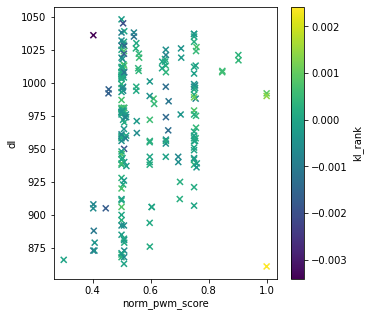

In [51]:
plot_2d_scatter_colors(df, 'norm_pwm_score',  'dl', 'kl_rank', plotsize=(5,5))

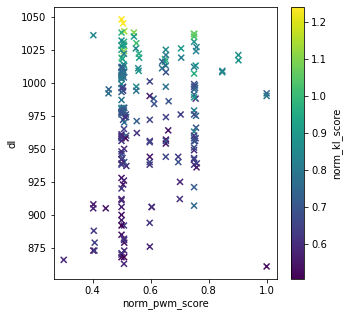

In [52]:
plot_2d_scatter_colors(df, 'norm_pwm_score',  'dl', 'norm_kl_score', plotsize=(5,5))

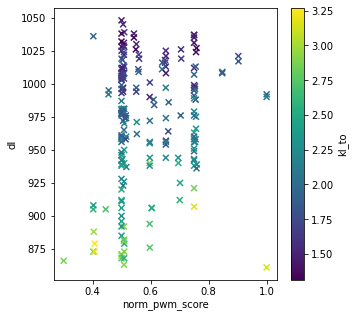

In [53]:
plot_2d_scatter_colors(df, 'norm_pwm_score',  'dl', 'kl_to', plotsize=(5,5))

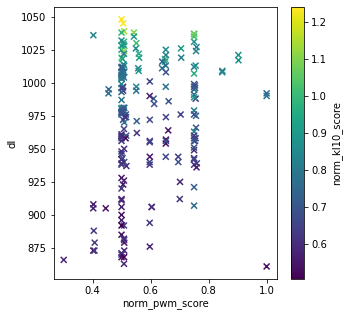

In [54]:
plot_2d_scatter_colors(df, 'norm_pwm_score',  'dl', 'norm_kl10_score', plotsize=(5,5))

----

# An LCP-based word extraction procedure

We evaluated the use of a procedure to extract varibale-length words by their properties on the LCP array.<br>
More in particular we are interested in merging words which are locate next each other in the suffix arry by looking at the value of thier corresponding LCP data<br>
Thus, we aim at extracting a set of *clusters* in the LCP array such that each cluster defines a specific set of suffixxes sharing a common prefix.<br>

A possible usage of the clustering result is to use the common prefix as representative word for the entire LCP cluster.

In [55]:
import numpy as np
import pandas as pd


def find_clusters_ferragina(lcp, min_lcp_val=3):
    """
    Find clusters of sequences by looking at local minima
    on the LCP-array.

    :param esa: (Esa) enhanced suffix array of a set of
                        input sequences
    :param min_lcp_val: (int) minimum threshold on the LCP value
                                to put two consecutive suffixes in
                                a cluster
    :return: cluster starts and ends points defined
    """
    lcp_len = len(lcp)

    clust_starts = []
    clust_lengths = []
    clust_ends = []

    start = None

    for i in range(1, lcp_len):

        if (start != None and
                (lcp[i] < min_lcp_val or
                 (lcp[i] < lcp[i - 1] and lcp[i] < lcp[i + 1]))):
            clust_starts.append(start)
            clust_ends.append(i)
            clust_lengths.append(i - start + 1)

            start = None

        if (start == None and lcp[i] >= min_lcp_val):
            start = i

        elif (start == None and lcp[i] < min_lcp_val):
            continue

    if (start != None):
        clust_starts.append(start)
        clust_ends.append(i)
        clust_lengths.append(i - start + 1)

    assert len(clust_starts) == len(clust_ends)

    return clust_starts, clust_ends

# end of __find_clusters_ferragina()


def merge_clusters(lcp, clusters_starts, clusters_ends):
    """
    Procedure to enlarge clusters computed with the previous method.
    The clusters are merged together using a hierarchical clustering
    like procedure

    :param esa: (Esa) enhanced suffix array with cluster starts
                        and ends points defined
    :return: enhanced suffix array with merged clusters
    """

    max_array = [-1] * len(clusters_starts)
    min_array = [-1] * len(clusters_starts)

    clusters_num = len(clusters_starts)

    for i in range(clusters_num):
        max_array[i] = max(lcp[clusters_starts[i]:(clusters_ends[i] + 1)])
        min_array[i] = lcp[clusters_ends[i]]

    clust_starts_new = []
    clust_ends_new = []
    max_arr_new = []
    min_arr_new = []

    j = 0
    while (j < 100000):  # set an upperbound of iterations (never reached)

        clusters_num = len(clusters_starts)

        for i in range(0, clusters_num - 1, 2): # step by 2
            if (min_array[i] / max_array[i + 1]) > 0.5:
                # merge the two clusters
                clust_starts_new.append(clusters_starts[i])
                clust_ends_new.append(clusters_ends[i + 1])
                max_arr_new.append(max(max_array[i], max_array[i + 1]))
                min_arr_new.append(min_array[i + 1])

            else:
                clust_starts_new.append(clusters_starts[i])
                clust_starts_new.append(clusters_starts[i + 1])
                clust_ends_new.append(clusters_ends[i])
                clust_ends_new.append(clusters_ends[i + 1])
                max_arr_new.append(max_array[i])
                max_arr_new.append(max_array[i + 1])
                min_arr_new.append(min_array[i])
                min_arr_new.append(min_array[i + 1])

        assert (len(clust_starts_new) == len(clust_ends_new))
        assert (len(clust_starts_new) == len(max_arr_new))
        assert (len(clust_starts_new) == len(min_arr_new))

        if not len(clust_starts_new) < clusters_num:  # no clusters have been merged
            break

        else:
            clusters_starts = clust_starts_new
            clusters_ends = clust_ends_new
            max_array = max_arr_new
            min_array = min_arr_new

            # reset for new iteration
            clust_starts_new = []
            clust_ends_new = []
            max_arr_new = []
            min_arr_new = []

            j += 1

    return clust_starts_new, clust_ends_new

In [56]:
import pandas 
epeaks, es2n, egs = read_global_sequence(iipeaks)
edf = pandas.read_csv(iipeaks_nelsa)
print(len(epeaks), len(es2n), len(egs))
e_dnesa = DNESA(list(edf.sa), list(edf.lcp), list(edf.nn), list(edf.dl), egs)

1069 1069 815480


In [57]:
elcp = [ min( e_dnesa.lcp[i], e_dnesa.nn[i] ) for i in range(len(e_dnesa.lcp))]

ics, ice = find_clusters_ferragina(elcp)
cs, ce = merge_clusters(elcp, ics, ice)

c_size = dict()
for i in range(len(cs)):
    l = ce[i] - cs[i]
    c_size[l] = c_size.get(l, 0) +1

print('number of LCP clusters', len(cs))
print('-'*10)
print('cluster size / number of clusters')
for k,v in sorted(c_size.items()):
    print(k,v)

number of LCP clusters 16742
----------
cluster size / number of clusters
2 189
3 314
4 331
5 345
6 327
7 293
8 330
9 343
10 271
11 284
12 305
13 304
14 267
15 266
16 257
17 259
18 252
19 238
20 236
21 221
22 249
23 227
24 236
25 224
26 218
27 204
28 217
29 197
30 166
31 194
32 184
33 188
34 193
35 178
36 176
37 158
38 150
39 165
40 154
41 158
42 171
43 154
44 130
45 146
46 144
47 130
48 120
49 140
50 121
51 116
52 111
53 124
54 139
55 105
56 131
57 98
58 113
59 125
60 114
61 109
62 108
63 100
64 113
65 80
66 94
67 87
68 76
69 75
70 93
71 86
72 96
73 92
74 69
75 78
76 85
77 78
78 72
79 72
80 74
81 71
82 78
83 44
84 58
85 63
86 67
87 54
88 66
89 57
90 60
91 48
92 54
93 39
94 39
95 46
96 60
97 42
98 38
99 48
100 48
101 52
102 34
103 38
104 67
105 46
106 40
107 45
108 44
109 40
110 31
111 33
112 39
113 32
114 35
115 32
116 28
117 36
118 27
119 40
120 27
121 35
122 22
123 25
124 30
125 28
126 27
127 31
128 21
129 25
130 21
131 21
132 17
133 22
134 13
135 20
136 20
137 20
138 19
139 20
140 

In [58]:
word_lengths = dict()
lcp_extracted_words = list()
ss = set()
for i in range(len(cs)):
    if ce[i]-cs[i] > 3:
        min_lcp = min(e_dnesa.lcp[ cs[i]+1 : ce[i]-1 ])
        word_lengths[min_lcp] = word_lengths.get(min_lcp, 0)+1
        word = egs[ e_dnesa.sa[ cs[i] ] :  e_dnesa.sa[ cs[i] ] + min_lcp ]
        lcp_extracted_words.append(word)
        if word == 'CCA':
            print(word, ce[i]-cs[i], len(set(e_dnesa.dl[cs[i] : ce[i]]))  )
        if i>10000 and i < 10050:
            print(word, ce[i]-cs[i], len(set(e_dnesa.dl[cs[i] : ce[i]]))  )
        if len(word)==3:
            ss.add(word[:3])
        if len(word)==10 and i>12000 and i < 12200:
            print('@',word, ce[i]-cs[i], len(set(e_dnesa.dl[cs[i] : ce[i]]))  )
        if len(word)==7 and i>8000 and i < 8200:
            print('#',word, ce[i]-cs[i], len(set(e_dnesa.dl[cs[i] : ce[i]]))  )

print('-'*20)
print(sorted(ss))
print('-'*20)
print(len(lcp_extracted_words))
print('-'*10)
print('word length / number of words')
for k,v in sorted(word_lengths.items()):
    print(k,v)
    
print(lcp_extracted_words[:100])

CCA 131 119
# CTTCGTT 16 12
# CTTCTAC 12 12
# CTTCTGA 44 43
# CTTCTGA 49 48
# CTTCTGC 43 42
# CTTCTGC 16 14
# CTTCTGC 18 18
# CTTCTTC 67 66
# CTTCTTT 68 60
# CTTGAAC 14 14
# CTTGAAG 44 42
# CTTGAAT 71 66
# CTTGACA 29 29
# CTTGACC 9 9
# CTTGACT 51 45
# CTTGAGC 28 28
# CTTGAGG 26 24
# CTTGCAG 70 69
# CTTGCAT 48 46
# CTTGCTT 48 45
# CTTGGAC 39 38
# CTTGGAG 38 37
# CTTGGCT 77 74
# CTTGGTA 17 17
# CTTGTCA 21 19
# CTTGTCT 71 69
# CTTGTGT 51 51
# CTTGTTT 101 88
# CTTTAAC 23 22
# CTTTAAG 60 58
# CTTTAAT 70 66
# CTTTATC 36 35
# CTTTATG 29 29
# CTTTATT 106 104
# CTTTCAA 68 68
# CTTTCAC 88 83
# CTTTCAG 92 90
# CTTTCAT 115 111
# CTTTCCT 119 113
# CTTTCTC 82 74
# CTTTCTG 94 89
# CTTTCTT 170 150
# CTTTGAG 96 87
# CTTTGAT 76 72
# CTTTGCA 64 64
# CTTTGCT 50 50
# CTTTGGG 28 26
# CTTTGGG 31 31
# CTTTTAA 75 70
# CTTTTAC 71 66
# CTTTTAG 76 72
# CTTTTAT 111 103
# CTTTTCA 60 60
# CTTTTGC 39 39
# CTTTTGT 51 47
# CTTTTTA 121 107
# CTTTTTC 150 133
# CTTTTTG 113 104
# CTTTTTT 193 165
# GAAAAAA 87 81
# GAAAAAA 7

In [59]:
discarded = set()
extracted_words = set()
for w in lcp_extracted_words:
    if '$' not in w:
        extracted_words.add(w)
    else:
        discarded.add(w)

print('discarded words because of $')
print(discarded)
print('unredundant extracted words')
extracted_words = sorted(extracted_words)
print(len(extracted_words))

discarded words because of $
set()
unredundant extracted words
12957


In [60]:
rpeaks, rs2n, rgs = read_global_sequence(ireextraction)
rdf = pandas.read_csv(ireextraction_nelsa)
print(len(rpeaks), len(rs2n), len(rgs))
r_dnesa = DNESA(list(rdf.sa), list(rdf.lcp), list(rdf.nn), list(rdf.dl), rgs)

ctcf = read_jaspar(imotif)

1069 1069 815480


In [64]:
d_kl_rank = dict()
d_norm_kl_rank = dict()

for k in range(2,10):
    print(k)
    k_kl_rank, k_norm_kl_rank =  get_kl_scores(k, egs, e_dnesa, rgs, r_dnesa)
    for s in k_kl_rank:
        d_kl_rank[ s[1] ] = s[0]
    for s in k_norm_kl_rank:
        d_norm_kl_rank[ s[1] ] = s[0]

2
3
4
5
6
7
8
9


In [65]:
seq_lengths = dict()
for i in range(len(epeaks)):
    seq_lengths[i] = len(epeaks[i][0])
nof_peaks = len(epeaks)

kl_rank = list()
norm_kl_rank = list()
mult = list()
dl = list()
norm_pwm_score = list()
norm_kl = list()
kl_to = list()
symmetric_kl = list()
jaccard = list()

for kmer in extracted_words:
    
    #print(kmer, len(kmer), len(ctcf))
    
    if len(kmer) <= len(ctcf):
        norm_pwm_score.append( get_normalized_motif_score(ctcf, kmer)[0] )
    else:
        norm_pwm_score.append( 1.1)
    
    kl_rank.append( d_kl_rank.get(kmer, 0) )
    norm_kl_rank.append( d_norm_kl_rank.get(kmer, 0) )
    
    norm_kl.append( calculate_norm_kl(kmer, egs, e_dnesa, rgs, r_dnesa, seq_lengths, nof_peaks ) )
    
    ks, ke = e_dnesa.search(kmer)
    if ks:
        rs, rf = r_dnesa.search(kmer)
        if rs:
            d1 = get_m_distr( e_dnesa, ks, ke )
            d2 = get_m_distr( r_dnesa, rs, rf )
            jaccard.append(calulcate_generalized_jaccard(d1,d2))
            
            d1 = make_prob_distr( add_unzeros( m_dsitr_to_seq_freq( get_m_distr( e_dnesa, ks, ke ), seq_lengths, len(kmer) ), nof_peaks) )
            d2 = make_prob_distr( add_unzeros( m_dsitr_to_seq_freq( get_m_distr( r_dnesa, rs, rf ), seq_lengths, len(kmer) ), nof_peaks) )
            kl_to.append( calculate_kl(d1,d2) )
            symmetric_kl.append( calculate_symmetric_kl(d1,d2) )
        else:
            symmetric_kl.append(0)
            jaccard.append(0)
            kl_to.append(0)
        
        mult.append(ke-ks)
        dl.append( len(set(edf.dl[ks:ke])))
    else:
        mult.append(0)
        dl.append(0)
        symmetric_kl.append(0)
        jaccard.append(0)
        kl_to.append(0)
        
import pandas
exp1_df = pandas.DataFrame()
exp1_df['kmer'] = [kmer for kmer in extracted_words]
exp1_df['norm_pwm_score'] = norm_pwm_score
exp1_df['dl'] = dl
exp1_df['mult'] = mult
exp1_df['kl_rank'] = kl_rank
exp1_df['norm_kl_rank'] = norm_kl_rank
exp1_df['norm_kl_score'] = norm_kl
exp1_df['kl_to'] = kl_to
exp1_df['symmetric_kl'] = symmetric_kl
exp1_df['jaccard'] = jaccard

print('-'*40)
display(exp1_df)

exp1_df.to_csv('scores.best5000.re-extract.lcp-hierarchical-clustering.csv')

----------------------------------------


,kmer,norm_pwm_score,dl,mult,kl_rank,norm_kl_rank,norm_kl_score,kl_to,symmetric_kl,jaccard
0,AAA,0.390215,1068,26274,-0.005678,0.070813,2.305610,1.182381,0.780074,1.963970
1,AAAAAAA,1.100000,278,1159,-0.000609,0.000000,0.764757,8.706376,8.606926,12.311321
2,AAAAAAATT,1.100000,46,47,-0.000020,0.583341,0.997902,9.655871,9.427963,56.500000
3,AAAAAAC,1.100000,137,154,-0.000062,0.327066,0.916217,8.873135,8.782219,19.764706
4,AAAAAAG,1.100000,232,285,-0.000046,0.336184,0.797112,7.882987,7.881671,9.315789
...,...,...,...,...,...,...,...,...,...,...
12952,TTTTTTTTTTTG,1.100000,27,28,0.000000,0.000000,1.090762,10.459100,9.641383,0.000000
12953,TTTTTTTTTTTT,1.100000,49,314,0.000000,0.000000,1.010463,11.902373,11.465789,162.400000
12954,TTTTTTTTTTTTT,1.100000,40,264,0.000000,0.000000,1.013200,11.939679,11.487663,225.000000
12955,TTTTTTTTTTTTTT,1.100000,33,223,0.000000,0.000000,1.016976,11.986101,11.545417,558.000000


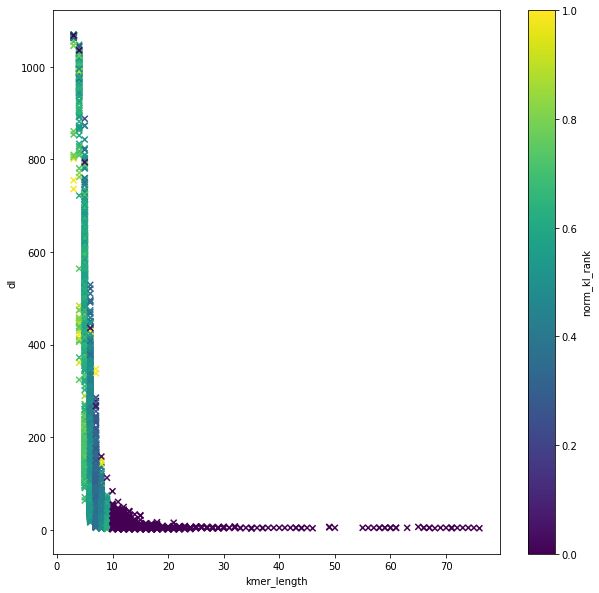

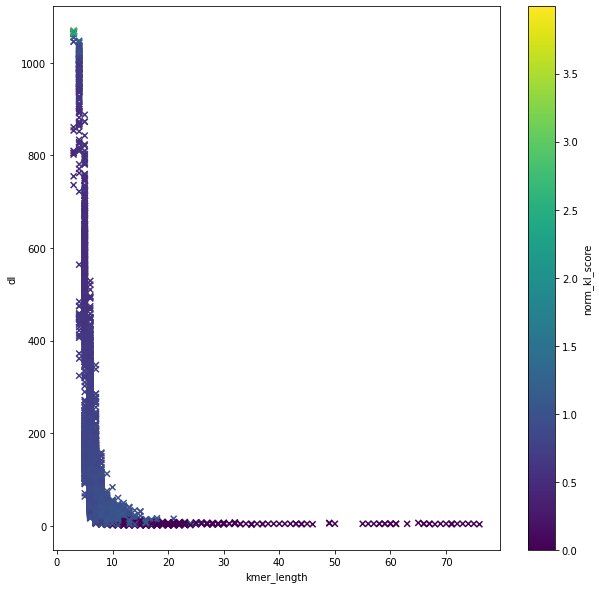

In [66]:
df = exp1_df

df['kmer_length'] = [len(v) for v in df.kmer]
plot_2d_scatter_colors(df, 'kmer_length',  'dl', 'norm_kl_rank', plotsize=(10,10))
plot_2d_scatter_colors(df, 'kmer_length',  'dl', 'norm_kl_score', plotsize=(10,10))

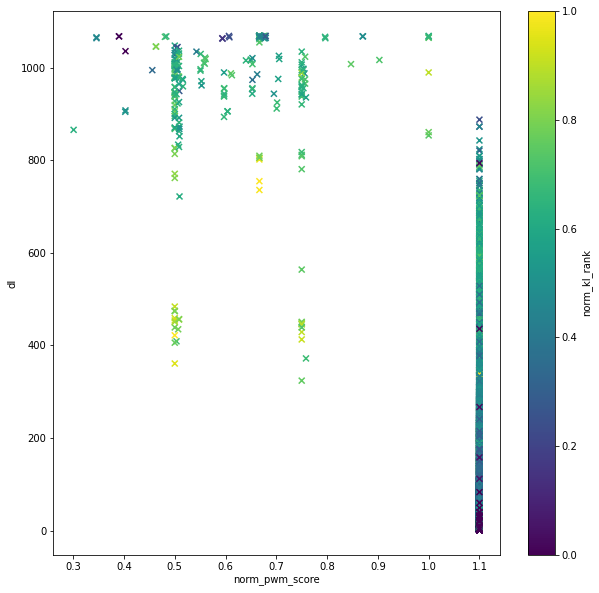

In [67]:
plot_2d_scatter_colors(df, 'norm_pwm_score',  'dl', 'norm_kl_rank', plotsize=(10,10))

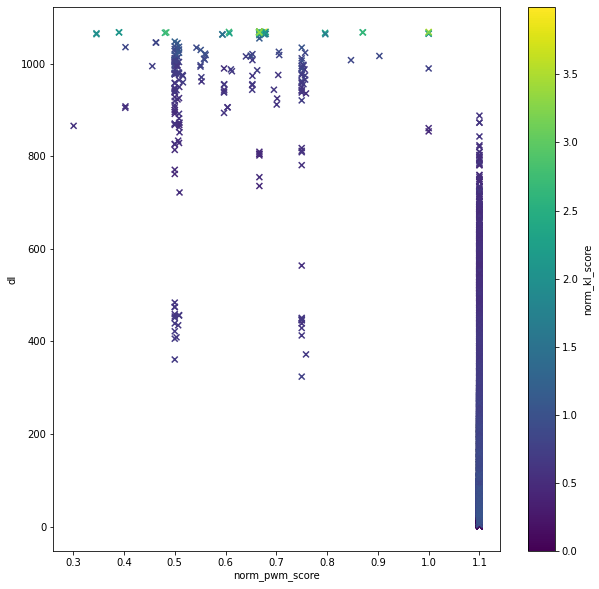

In [68]:
plot_2d_scatter_colors(df, 'norm_pwm_score',  'dl', 'norm_kl_score', plotsize=(10,10))

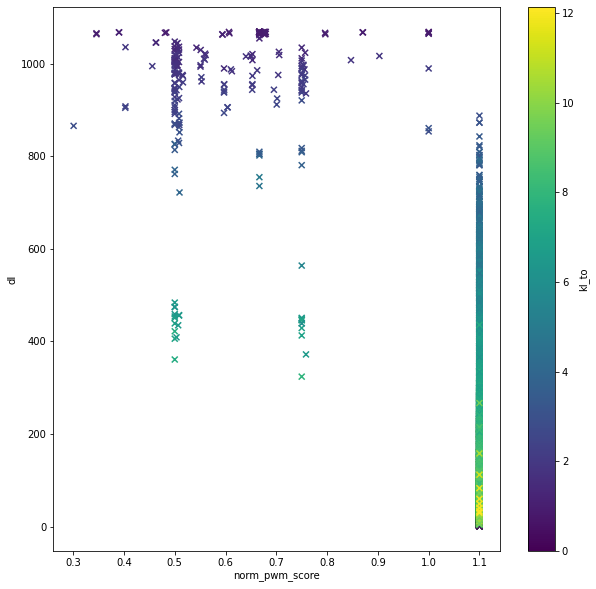

In [69]:
plot_2d_scatter_colors(df, 'norm_pwm_score',  'dl', 'kl_to', plotsize=(10,10))

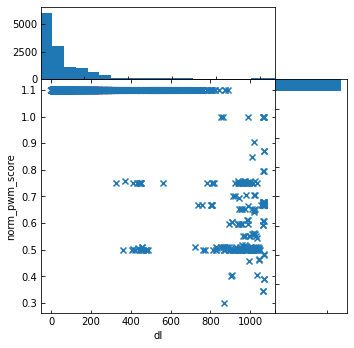

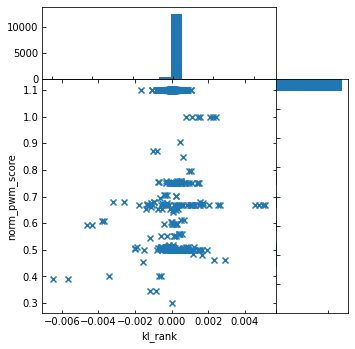

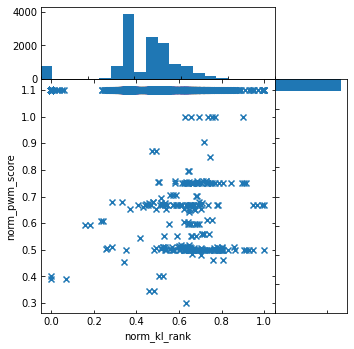

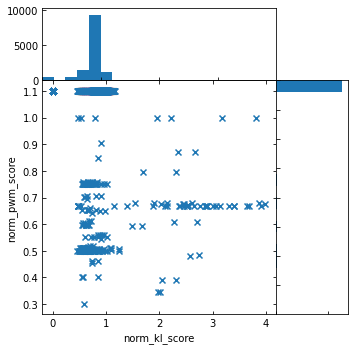

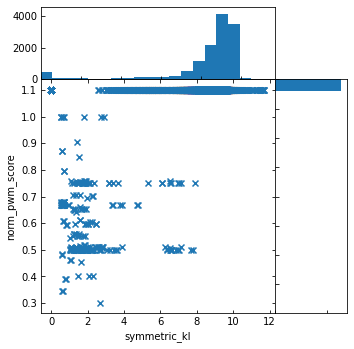

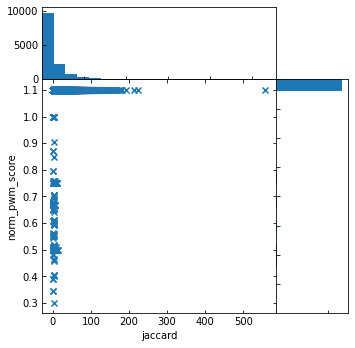

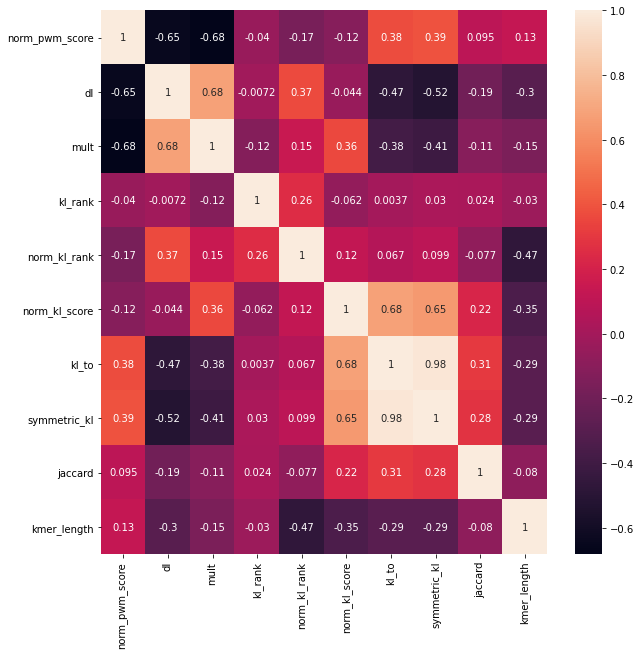

In [72]:
%matplotlib inline
df = exp1_df

plot_2d_scatter(df, 'dl', 'norm_pwm_score')

plot_2d_scatter(df, 'kl_rank', 'norm_pwm_score')
plot_2d_scatter(df, 'norm_kl_rank', 'norm_pwm_score')
plot_2d_scatter(df, 'norm_kl_score', 'norm_pwm_score')
plot_2d_scatter(df, 'symmetric_kl', 'norm_pwm_score')
plot_2d_scatter(df, 'jaccard', 'norm_pwm_score')

import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

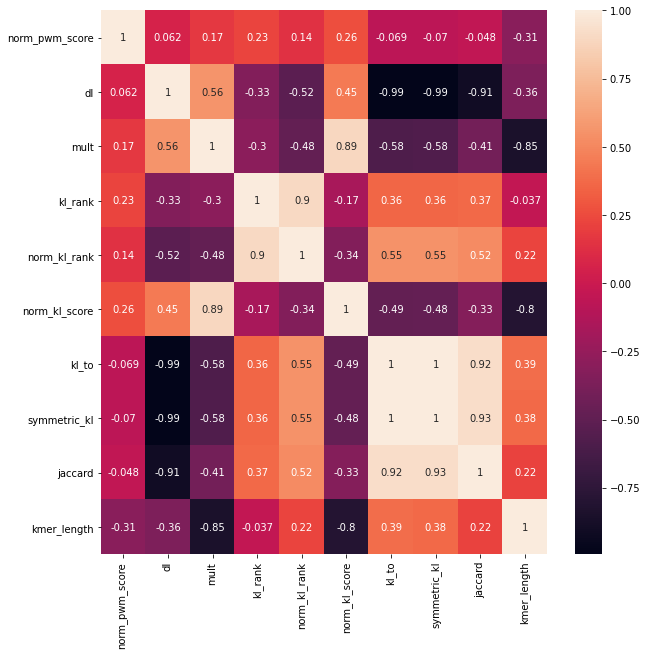

In [73]:

import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
corrMatrix = df[df.norm_pwm_score <= 1.0].corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

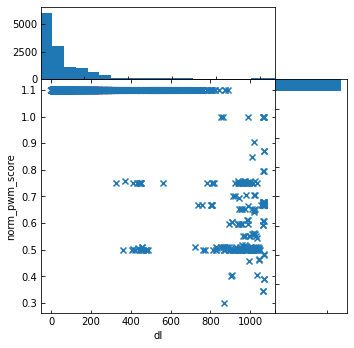

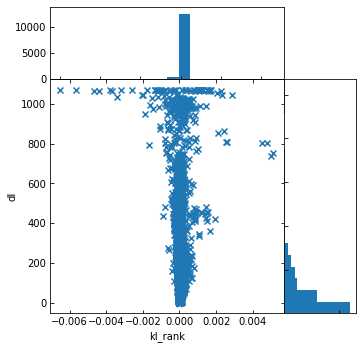

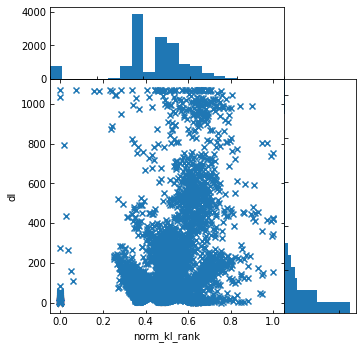

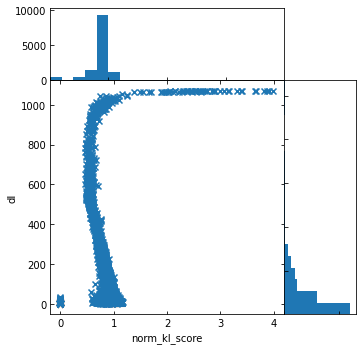

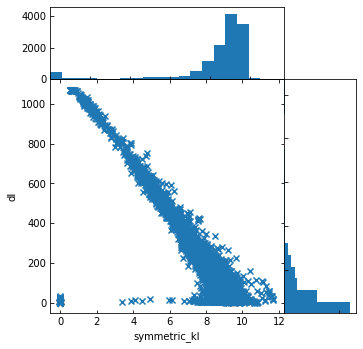

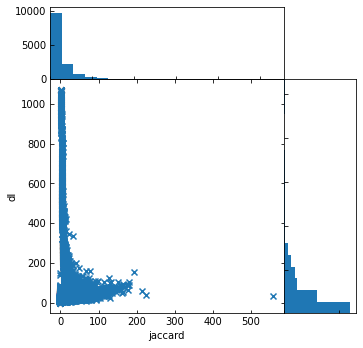

In [74]:
%matplotlib inline
df = exp1_df

plot_2d_scatter(df, 'dl', 'norm_pwm_score')

plot_2d_scatter(df, 'kl_rank', 'dl')
plot_2d_scatter(df, 'norm_kl_rank', 'dl')
plot_2d_scatter(df, 'norm_kl_score', 'dl')
plot_2d_scatter(df, 'symmetric_kl', 'dl')
plot_2d_scatter(df, 'jaccard', 'dl')


In [75]:
wlist = sorted(extracted_words)[:100]
short_words = list()

#for w in wlist:
#    print(w)

def lcp_2by2(a,b):
    if len(a) > len(b):
        return 0
    for l in range(len(a)):
        if a[l] != b[l]:
            return l
    return l+1

print(lcp_2by2('AAA','AAAA'))

#for i in range(len(wlist)):
i = 0
while True:
    if i >= len(wlist):
        break
    if i <len(wlist)-1:
        j = i +1
        print(i, wlist[i], wlist[i+1], lcp_2by2(wlist[j-1], wlist[j]), len(wlist[i]), len(wlist[i+1]))
        while (j<len(wlist)) and (lcp_2by2(wlist[j-1], wlist[j]) == len(wlist[j-1])):
            j += 1
        print(j)
        short_words.append(wlist[i])
        i = j
    else:
        short_words.append(wlist[i])
        i += 1

print( sorted(set(short_words)))
        

3
0 AAA AAAAAAA 3 3 7
3
3 AAAAAAC AAAAAAG 6 7 7
4
4 AAAAAAG AAAAAAGA 7 7 8
6
6 AAAAAAGT AAAAAAT 0 8 7
7
7 AAAAAAT AAAAAATT 7 7 8
11
11 AAAAAATTT AAAAAC 0 9 6
12
12 AAAAAC AAAAACA 6 6 7
14
14 AAAAACT AAAAAG 0 7 6
15
15 AAAAAG AAAAAGA 6 6 7
18
18 AAAAAGAG AAAAAGC 0 8 7
19
19 AAAAAGC AAAAAGG 6 7 7
20
20 AAAAAGG AAAAAGGA 7 7 8
22
22 AAAAAGT AAAAATA 5 7 7
23
23 AAAAATA AAAAATAA 7 7 8
25
25 AAAAATC AAAAATG 6 7 7
26
26 AAAAATG AAAAATGC 7 7 8
28
28 AAAAATT AAAAATTA 7 7 8
31
31 AAAAATTT AAAAATTTAA 8 8 10
33
33 AAAAC AAAACA 5 5 6
37
37 AAAACAT AAAACATA 7 7 8
39
39 AAAACATT AAAACC 0 8 6
40
40 AAAACC AAAACCA 6 6 7
43
43 AAAACCAT AAAACCT 0 8 7
44
44 AAAACCT AAAACG 0 7 6
45
45 AAAACG AAAACGA 6 6 7
47
47 AAAACT AAAACTAA 6 6 8
49
49 AAAACTCT AAAACTG 0 8 7
50
50 AAAACTG AAAACTT 6 7 7
51
51 AAAACTT AAAACTTA 7 7 8
53
53 AAAAG AAAAGA 5 5 6
58
58 AAAAGAC AAAAGACA 7 7 8
60
60 AAAAGAG AAAAGATT 6 7 8
61
61 AAAAGATT AAAAGC 0 8 6
62
62 AAAAGC AAAAGCA 6 6 7
65
65 AAAAGCAT AAAAGCT 0 8 7
66
66 AAAAGCT AAAAGG 0 7 6